In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import math
import os
from collections import Counter
import json
from decimal import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset
import glob

In [2]:
from decimal import *
getcontext().prec = 50


def decimal_from_value(value):
    return Decimal(value)


def str_from_value(value):
    return str(value)


all_df=pd.read_csv('all.csv', converters={'objective':decimal_from_value, 'solution':str_from_value})

In [3]:
folder_path = ''

In [4]:
pd.set_option('display.float_format', '{:.25f}'.format)

In [5]:
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['lmodern'],
    'font.size': 20,
    'axes.titlesize': 20,        
    'axes.labelsize': 20,        
    'xtick.labelsize': 18,       
    'ytick.labelsize': 20     
})

In [6]:
def limit_after_offset(limit, offset=3):
    return  max(1, min(int(math.floor(limit)), int(math.floor(limit*1.1 - offset))))

In [7]:
def plot_stacked_bar_with_hatch(x, base_vals, float_vals, total, colors, labels):
    bottom = 0


    reorder = [1, 2, 0]
    base_vals = [base_vals[i] for i in reorder]
    float_vals = [float_vals[i] for i in reorder]

    for i in range(3):
        base_height = base_vals[i] / total
        float_height = float_vals[i] / total if float_vals else 0


        plt.bar(x, base_height, bottom=bottom, color=colors[i], width=0.9)

        # Plot hatch overlay
        if float_height > 0:
            plt.bar(x, float_height, bottom=bottom, 
                    hatch='///', color='none', edgecolor='black', width=0.9,
                    label='Float cases' if x == 1 and i == 0 else "")
            plt.text(x+0.4, bottom + float_height + 0.002,f"{np.round(float_height * 100, 1)}%",ha='center', va='bottom', fontsize=14, color='black')



        # Add base % and label inside bar
        if base_height > 0.02:
            middle = bottom + base_height / 2 + 0.02
            plt.text(x+0.02, middle, f"{np.round(base_height * 100, 1)}%", 
                     ha='center', va='center', fontsize=16, color='black' , path_effects=[pe.withStroke(linewidth=4, foreground="white")], weight='bold')
            plt.text(x+0.02, middle - 0.04, labels[i], 
                     ha='center', va='center', fontsize=14, color='black' , path_effects=[pe.withStroke(linewidth=4, foreground="white")], weight='bold')

        bottom += base_height

In [8]:
def get_baseline_subset(df, node_range, density_range):
    return df[
        (df['nodes'] >= node_range[0]) & 
        (df['nodes'] < node_range[1]) & 
        (df['density'] >= density_range[0]) & 
        (df['density'] < density_range[1])
    ]


def read_da_file(folder, solver, name, limit):
    if solver == 'DAv3':
        fname = all_df[all_df['file']== f"./{solver}/{name}-{limit_after_offset(limit, 3)}-5.csv"]
        return fname
            

    elif solver == 'DAv2':
        fname =  all_df[all_df['file']== f"./{solver}/{name}-{limit:.3f}-5.csv"]
        return fname
        
    return None


flt_cases = []
def compare_solver(folder, solver, baseline_df, mqlib_name, da_column='objective', ref_column='objective'):
    all_results = []
    float_results = []


    for _, row in baseline_df.iterrows():
        name, limit = row['name'], row['limit']
        da_df = read_da_file(folder, solver, name, limit)
        if da_df is None:
            continue
        da_val = max(da_df['objective'])

        ref_path = all_df[all_df['file']==f"./{mqlib_name}/{name}-{limit:.3f}-5.csv"]
        ref_df = ref_path
        ref_val = max(ref_df['objective'])

        if ref_val != 0:
            ratio = da_val / ref_val
            all_results.append(ratio)
            if baseline_df[baseline_df['name'] == name]['int_only'].values == False :
                float_results.append(ratio)
                if ratio < 0.99:
                    flt_cases.append(name)
        elif ref_val == da_val:
            all_results.append(1.0)
            if baseline_df[baseline_df['name'] == name]['int_only'].values == False :
                float_results.append(1.0)
        else:
            print('Invalid result comparison.')

    return all_results, float_results #, flt_cases


def summarize_accuracy(results):
    win = sum(1 for v in results if v > 1)
    lose = sum(1 for v in results if v < 1)
    tie = sum(1 for v in results if v == 1)
    return win, lose, tie

# Choose a suitable time offset for DAv3

In [9]:
baseline= pd.read_csv('baseline.csv')
baseline=baseline[baseline['nodes'] >= 2048]
baseline=baseline[baseline['limit'] > 0.25 ]
#baseline=baseline[baseline['limit'] < 100 ]
#len(baseline)

In [10]:
solver = 'DAv3'
n_offset = 6
results = {name: {f"offset_{i}": None for i in range(n_offset)} for name in baseline['name']}

In [11]:
exceeding_limit_offset = []
for offset in range(n_offset):  
    j = 0  

    for name, limit in zip(baseline['name'], baseline['limit']):  
        if solver == 'DAv3':

            instance_runs = all_df[all_df['file'] == f"./{solver}/{name}-{limit_after_offset(limit, offset)}-5.csv"]
            max_obj = instance_runs['objective'].max() #pick the maximum objective value from the 5 runs
            best_rows = instance_runs[instance_runs['objective'] == max_obj] #pick all the runs that achieved this value
            best_row = best_rows.loc[best_rows['runtime'].idxmin()] #pick the one that has the minimum runtime

    
            time = best_row['runtime']


            results[name][f"offset_{offset}"] = max_obj #collect the best objective values for all offsets

            #count the amount of instances that DAv3 exceeds 10% of the time limit for.
            if time >= 1.1 * limit:
                j += 1


    exceeding_limit_offset.append(j) #add the counts per offset

In [12]:
offset_results = pd.DataFrame.from_dict(results, orient="index").reset_index()
offset_results.rename(columns={"index": "instance_name"}, inplace=True)
offset_results['max'] = offset_results.iloc[:, 1:].max(axis=1)

#There are 18 instances with objective value 0
#after manually checking, in all offsets and for all instances, the objective value 0 is achieved
zero_len = len(offset_results[(offset_results['max'] == 0) & (offset_results[offset_results['max'] == 0].iloc[:, 1:7].eq(0).all(axis=1))])

#we cannot devide by 0 to obtain a ratio: offset cut / max cut
offset_results = offset_results[(offset_results['max'] != 0)]
#calculate average accuracy of each offset compared to best objective value found over all offsets
avg_acc = []
for i in range(n_offset):
    avg_acc.append((sum(offset_results['offset_'+str(i)]/offset_results['max']) + zero_len)/(len(offset_results) + zero_len)) 
    #zero_len accounts for the accuracy =1 of the 18 instances

print("instances exceeding 10% of the limit:", exceeding_limit_offset, "average accuracy:", avg_acc)

instances exceeding 10% of the limit: [150, 113, 47, 8, 3, 3] average accuracy: [Decimal('0.99997062380625302741362605618888463851836186160807'), Decimal('0.99991615352417293857651642366454565911957743826664'), Decimal('0.99983795416214647305914455435674756834324292715248'), Decimal('0.99976016355196230710169757011382654611091669037455'), Decimal('0.99964522978030919528932953209484021397889423915990'), Decimal('0.99955983075182887466489616023943171019282257673330')]


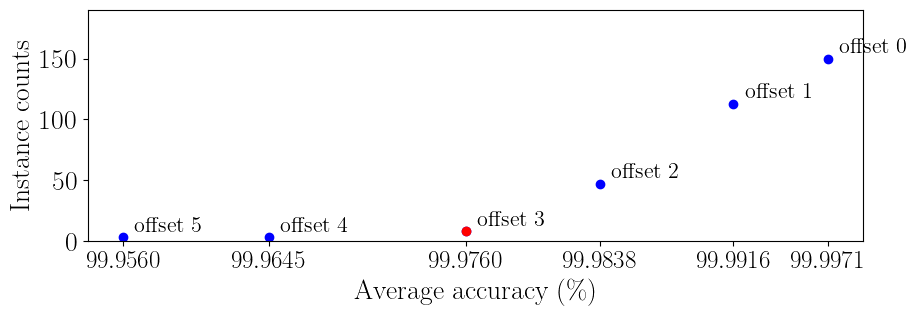

In [13]:
avg_acc=[np.round(100*float(i),4) for i in avg_acc]

fig, ax = plt.subplots(figsize=(10, 3))

ax.scatter(avg_acc, exceeding_limit_offset, color = 'blue')
ax.scatter(avg_acc[3],exceeding_limit_offset[3],color='red')
labels=['offset 0','offset 1','offset 2','offset 3','offset 4', 'offset 5']

for i, label in enumerate(labels):
    ax.annotate(label, (avg_acc[i], exceeding_limit_offset[i]), xytext=(+8, +4), textcoords='offset points', fontsize=16)

plt.xticks(avg_acc)
plt.ylim(0,190)
#plt.xlim(99.91,100.0055)


plt.ylabel("Instance counts")
plt.xlabel("Average accuracy (\%)")
#plt.savefig('plots/avg_acc_vs_10perlimit_without_small.pdf',bbox_inches="tight", dpi=300)
plt.show()

# Visualize instances considered

In [14]:
baseline= pd.read_csv('baseline.csv')
baseline= baseline[baseline['limit'] > 0.25]
#baseline= baseline[baseline['nodes'] > 20]
DAv2 = baseline[baseline['nodes'] < 2048]
DAv3=baseline[baseline['nodes'] >= 2048]

819.0


C:\Users\Salwa\AppData\Local\Temp\ipykernel_23180\1576673911.py:28: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axins2.set_ylim(0,10**3 + 500)


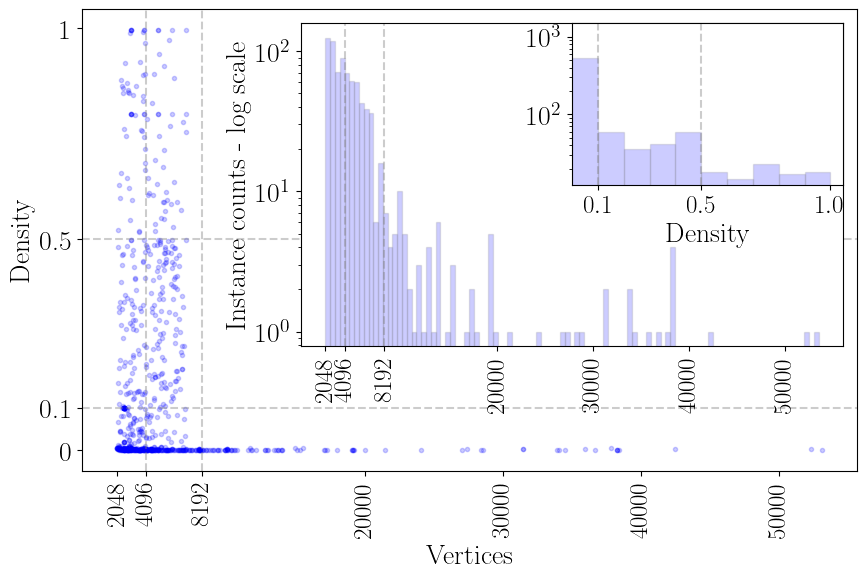

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(DAv3['nodes'],DAv3['density'], marker='.', color='blue', alpha=0.2)
plt.axvline(4096, linestyle='--', color='gray', alpha=0.4)
plt.axvline(8192, linestyle='--', color='gray', alpha=0.4)
plt.axhline(0.1, linestyle='--', color='gray', alpha=0.4)
plt.axhline(0.5, linestyle='--', color='gray', alpha=0.4)


plt.xlabel("Vertices")
plt.ylabel("Density")

plt.xticks(ticks=[2048, 4096, 8192]+ [20000 + x for x in range(0,40000, 10000)], labels=[2048, 4096, 8192] + [str(20000 + x) for x in range(0,40000, 10000)], rotation=90)
plt.yticks(ticks=[0, 0.1, 0.5, 1],  labels=[0, 0.1, 0.5, 1])

axins = inset_axes(ax, width="70%", height="70%")
bins = axins.hist(DAv3['nodes'],bins=np.arange(min(DAv3['nodes']), max(DAv3['nodes'])+500,500),edgecolor='gray', color='blue', alpha=0.2)
axins.set_ylabel("Instance counts - log scale")
axins.set_yscale('log')
#print(bins[1])

axins2 = inset_axes(ax, width="35%", height="35%")
bins = axins2.hist(DAv3['density'],bins=np.arange(0, 1.1,0.1), color='blue', edgecolor='gray', alpha=0.2)
print(sum(bins[0]))
axins2.set_xlabel("Density")
#axins2.set_ylabel("# of instances - log scale")
#axins2.set_ylim(0,700)
axins2.set_yscale("log")
axins2.set_ylim(0,10**3 + 500)
axins2.set_xlim(0,1.05)

axins.axvline(4096, linestyle='--', color='gray', alpha=0.4)
axins.axvline(8192, linestyle='--', color='gray', alpha=0.4)
ticks = [2048, 4096, 8192] + [20000 + x for x in range(0, 40000, 10000)]
labels = [2048, 4096, 8192] + [str(20000 + x) for x in range(0, 40000, 10000)]
axins.set_xticks(ticks)
axins.set_xticklabels(labels, rotation=90)

axins2.axvline(0.1, linestyle='--', color='gray', alpha=0.4)
axins2.axvline(0.5, linestyle='--', color='gray', alpha=0.4)
ticks = [0.1, 0.5, 1] 
labels = [0.1, 0.5, 1] 
axins2.set_xticks(ticks)

#plt.savefig('plots/instances_scatter_hist.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

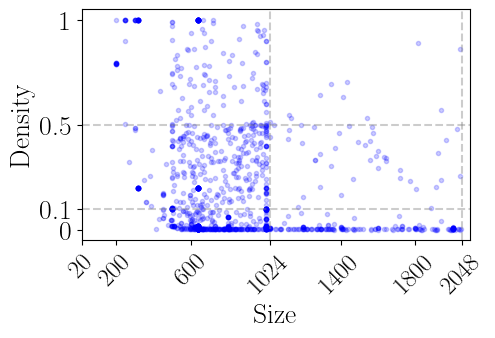

In [16]:
plt.figure(figsize=(5, 3))

plt.scatter(DAv2['nodes'],DAv2['density'], marker='.', color='blue', alpha=0.2)
plt.axvline(1024, linestyle='--', color='gray', alpha=0.4)
plt.axvline(2048, linestyle='--', color='gray', alpha=0.4)
plt.axhline(0.1, linestyle='--', color='gray', alpha=0.4)
plt.axhline(0.5, linestyle='--', color='gray', alpha=0.4)



plt.xticks(ticks=[20, 1024, 2048]+ [200 + x for x in range(0,800, 400)] + [1000 + x for x in range(400,2048, 400)], labels=[20, 1024, '   ' + str(2048)] + [str(200 + x) for x in range(0,800, 400)] + [str(1000 + x) for x in range(400,2048, 400)], rotation=45)
plt.yticks(ticks=[0, 0.1, 0.5, 1],  labels=[0, 0.1, 0.5, 1])

plt.xlabel("Size")
plt.ylabel("Density")
plt.xlim(20, 2090)

#plt.savefig('plots/small_instances_scatter.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

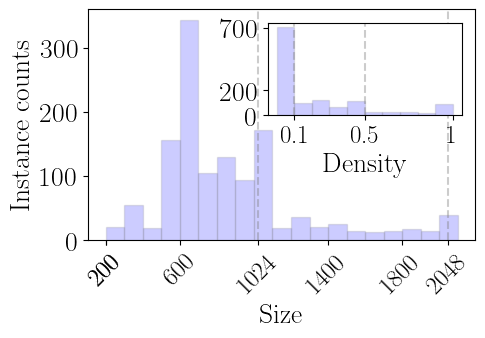

In [17]:
fig, ax = plt.subplots(figsize=(5, 3))
bins = ax.hist(DAv2['nodes'],bins=np.arange(min(DAv2['nodes']), max(DAv2['nodes'])+100,100),edgecolor='gray', color='blue', alpha=0.2)
ax.axvline(1024, linestyle='--', color='gray', alpha=0.4)
ax.axvline(2048, linestyle='--', color='gray', alpha=0.4)
ticks = [200, 1024, 2048] + [200 + x for x in range(0, 800, 400)] + [1000 + x for x in range(400, 1000, 400)]
labels = [200, 1024, 2048] + [str(200 + x) for x in range(0, 800, 400)] + [str(1000 + x) for x in range(400, 1000, 400)]
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=45)
ax.set_xlabel("Size")
ax.set_ylabel("Instance counts")


axins2 = inset_axes(ax, width="50%", height="40%")
bins = axins2.hist(DAv2['density'],bins=np.arange(0, 1.1,0.1), color='blue', edgecolor='gray', alpha=0.2)
axins2.axvline(0.1, linestyle='--', color='gray', alpha=0.4)
axins2.axvline(0.5, linestyle='--', color='gray', alpha=0.4)
ticks = labels = [0.1,0.5,1]
axins2.set_xticks(ticks)
axins2.set_xticklabels(labels, rotation=0)
axins2.set_xlabel("Density")
axins2.set_yticks([0,200,700])

#plt.savefig('plots/small_instances_hist.pdf', bbox_inches='tight', pad_inches=0)

# DA vs. best MQLib heuristics on medium–x-large instances

In [18]:
def collect_all_values(d):
    all_values = []
    for value in d.values():
        if isinstance(value, dict):  
            all_values.extend(value.get('all', []))  
    return all_values

def collect_flt_values(d):
    flt_values = []
    for value in d.values():
        if isinstance(value, dict):  
            flt_values.extend(value.get('flt', []))  
    return flt_values

### DAv2

In [19]:
# === Main Execution ===

baseline = pd.read_csv('baseline.csv')
baseline = baseline[baseline['limit']  >= 0.25] #first instances filter
solver = 'DAv2'

#second instances filter
categories = {
    'med_sp': ((2048, 4096), (0, 0.1), 'BURER2002'),
    'med_ba':     ((2048, 4096), (0.1, 0.5), 'PALUBECKIS2004bMST2'),
    'med_dens':     ((2048, 4096), (0.5, 1.1), 'PALUBECKIS2004bMST2'),
    'large_sp': ((4096, 8192), (0, 0.1), 'BURER2002'),
    'large_ba':     ((4096, 8192), (0.1, 0.5), 'PALUBECKIS2004bMST2'),
    'large_dens':     ((4096, 8192), (0.5, 1.1), 'PALUBECKIS2004bMST2'),
}

all_results = {}
for key, (node_range, density_range, ref_solver) in categories.items():
    subset = get_baseline_subset(baseline, node_range, density_range)
    res, res_flt = compare_solver(folder_path, solver, subset, ref_solver)
    all_results[key] = {'all': res, 'flt': res_flt}


summary = {}
for cat, res_dict in all_results.items():
    summary[cat] = summarize_accuracy(res_dict['all'])
    summary[cat + '_flt'] = summarize_accuracy(res_dict['flt'])

counts_v2 = []

for k, (win, lose, tie) in summary.items():
    print(f"{k}: Win={win}, Lose={lose}, Tie={tie}")
    counts_v2.append(win+lose+tie)

med_sp: Win=217, Lose=31, Tie=31
med_sp_flt: Win=82, Lose=20, Tie=6
med_ba: Win=39, Lose=16, Tie=23
med_ba_flt: Win=29, Lose=12, Tie=14
med_dens: Win=29, Lose=11, Tie=10
med_dens_flt: Win=19, Lose=6, Tie=2
large_sp: Win=131, Lose=31, Tie=9
large_sp_flt: Win=68, Lose=30, Tie=2
large_ba: Win=69, Lose=39, Tie=11
large_ba_flt: Win=47, Lose=24, Tie=5
large_dens: Win=26, Lose=11, Tie=4
large_dens_flt: Win=21, Lose=2, Tie=0


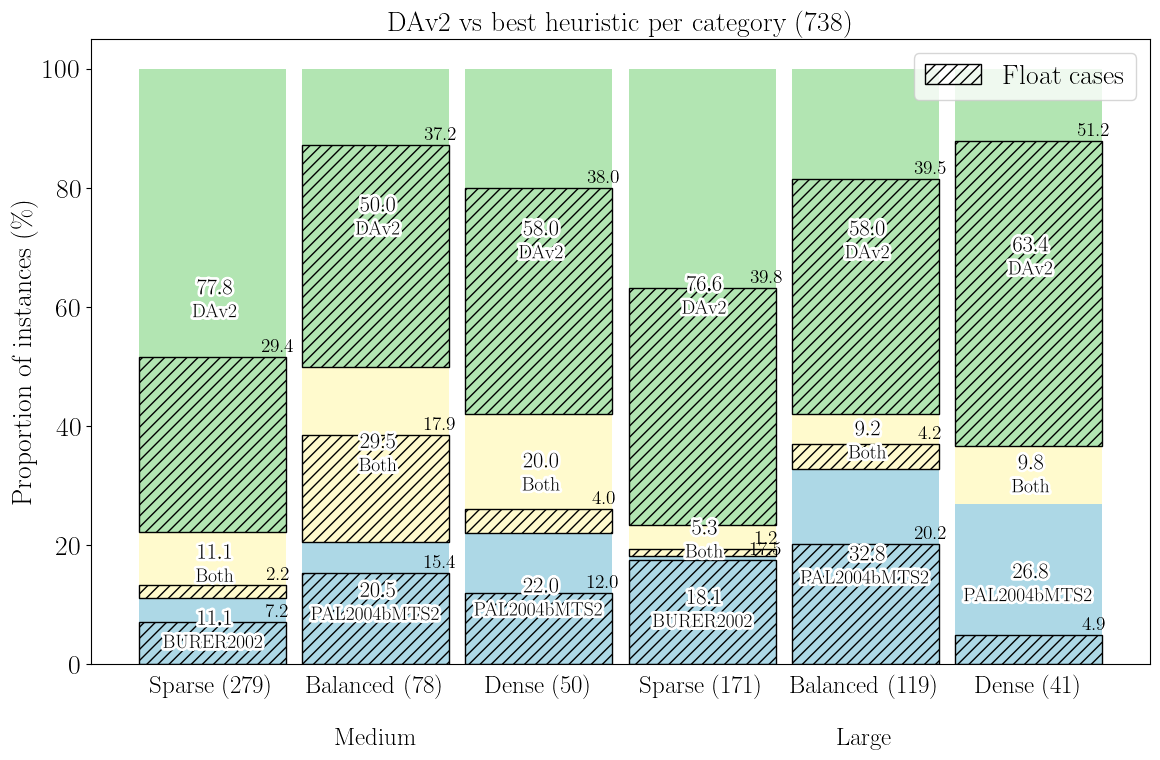

In [20]:
category_labels = {
    'med_sp': f'BURER2002 \n Sparse ({counts_v2[0]})',
    'med_ba': f'PAL2004bMTS2 \n  Balanced ({counts_v2[2]}) \n \n Medium',
    'med_dens': f'PAL2004bMTS2 \n Dense ({counts_v2[4]})',
    'large_sp': f'BURER2002 \n  Sparse ({counts_v2[6]})',
    'large_ba': f'PAL2004bMTS2 \n  Balanced ({counts_v2[8]}) \n \n Large',
    'large_dens': f'PAL2004bMTS2 \n  Dense ({counts_v2[10]})'
}


colors = ['#ADD8E6', '#FFFACD', '#B2E5B2']

labels = ['Both', 'DAv2']

plt.figure(figsize=(12, 8))
for i, key in enumerate(category_labels.keys(), 1):
    base_vals = summary[key]
    float_vals = summary.get(f"{key}_flt", (0, 0, 0))
    total = sum(base_vals)
    label = [category_labels[key].partition('\n')[0]] + labels
    plot_stacked_bar_with_hatch(i, base_vals, float_vals, total, colors, label)



plt.xticks(ticks=range(1, len(category_labels) + 1), labels={k: v.partition('\n')[2] for k, v in category_labels.items()}.values())
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels = [0, 20, 40, 60, 80, 100])
plt.title(f"DAv2 vs best heuristic per category ({sum([counts_v2[i] for i in [0,2,4,6,8,10]])})")
plt.tick_params(axis='x', which='both', bottom=False, top=False)  # hides tick marks
plt.legend()
plt.ylabel("Proportion of instances (\%)")
plt.tight_layout()

#plt.savefig('plots/DAv2_vs_best_heuristics_per_category.pdf',bbox_inches="tight", dpi=300)

plt.show()

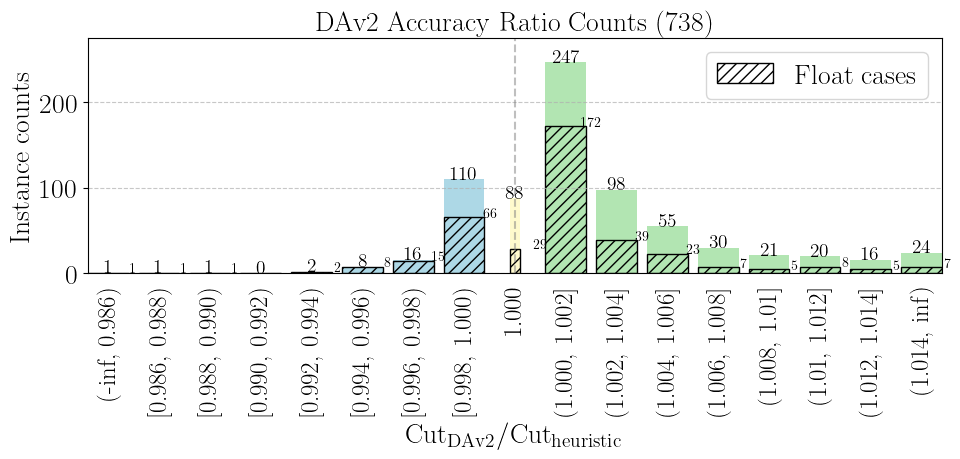

In [21]:
n_colors = 8
colors =  ['#ADD8E6' for i in range(1,n_colors+1)][::-1]
colors = colors + ['#FFFACD']
colors = colors + ['#B2E5B2' for i in range(1,n_colors+1)]

labels = [
    "(-inf, 0.986)","[0.986, 0.988)","[0.988, 0.990)", "[0.990, 0.992)", "[0.992, 0.994)",
    "[0.994, 0.996)", "[0.996, 0.998)",
    "[0.998, 1.000)", "{1.000}", "(1.000, 1.002]","(1.002, 1.004]",
     "(1.004, 1.006]", "(1.006, 1.008]",
     "(1.008, 1.01]","(1.01, 1.012]","(1.012, 1.014]", "(1.014, inf)"]



widths = [
    0.2 if lab == "{1.000}" else
    0.8
    for lab in labels
]

acc_v2_list = np.array(collect_all_values(all_results))
acc_v2_flt = np.array(collect_flt_values(all_results))

bin_indices = np.full(acc_v2_list.shape, -1)

# assign bins
bin_indices[acc_v2_list < 0.986] = 0
bin_indices[(acc_v2_list >= 0.986) & (acc_v2_list < 0.988)] = 1
bin_indices[(acc_v2_list >= 0.988) & (acc_v2_list < 0.990)] = 2
bin_indices[(acc_v2_list >= 0.990) & (acc_v2_list < 0.992)] = 3
bin_indices[(acc_v2_list >= 0.992) & (acc_v2_list < 0.994)] = 4
bin_indices[(acc_v2_list >= 0.994) & (acc_v2_list < 0.996)] = 5
bin_indices[(acc_v2_list >= 0.996) & (acc_v2_list < 0.998)] = 6
bin_indices[(acc_v2_list >= 0.998) & (acc_v2_list < 1.000)] = 7
bin_indices[acc_v2_list==1] = 8
bin_indices[(acc_v2_list > 1.000) & (acc_v2_list <= 1.002)] = 9
bin_indices[(acc_v2_list > 1.002) & (acc_v2_list <= 1.004)] = 10
bin_indices[(acc_v2_list > 1.004) & (acc_v2_list <= 1.006)] = 11
bin_indices[(acc_v2_list > 1.006) & (acc_v2_list <= 1.008)] = 12
bin_indices[(acc_v2_list > 1.008) & (acc_v2_list <= 1.01)] = 13
bin_indices[(acc_v2_list > 1.01) & (acc_v2_list <= 1.012)] = 14
bin_indices[(acc_v2_list > 1.012) & (acc_v2_list <= 1.014)] = 15
bin_indices[acc_v2_list > 1.014] = 16


counter = Counter(bin_indices)
counts = [counter.get(i, 0) for i in range(len(labels))]

total = sum(counts)
portions = [c / total for c in counts]

# Plot count
plt.figure(figsize=(10, 5))
plt.bar(labels, counts, color = colors, width=widths)
plt.axvline(8, linestyle='--', color='gray',alpha=0.5)
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center', fontsize=14, color='black')


# assign bins for float cases
bin_indices_flt = np.full(acc_v2_flt.shape, -1)
bin_indices_flt [acc_v2_flt < 0.986] = 0
bin_indices_flt [(acc_v2_flt >= 0.986) & (acc_v2_flt < 0.988)] = 1
bin_indices_flt [(acc_v2_flt >= 0.988) & (acc_v2_flt < 0.990)] = 2
bin_indices_flt [(acc_v2_flt >= 0.990) & (acc_v2_flt < 0.992)] = 3
bin_indices_flt [(acc_v2_flt >= 0.992) & (acc_v2_flt < 0.994)] = 4
bin_indices_flt [(acc_v2_flt >= 0.994) & (acc_v2_flt < 0.996)] = 5
bin_indices_flt [(acc_v2_flt >= 0.996) & (acc_v2_flt < 0.998)] = 6
bin_indices_flt [(acc_v2_flt >= 0.998) & (acc_v2_flt < 1.000)] = 7
bin_indices_flt [acc_v2_flt==1] = 8
bin_indices_flt [(acc_v2_flt > 1.000) & (acc_v2_flt <= 1.002)] = 9
bin_indices_flt [(acc_v2_flt > 1.002) & (acc_v2_flt <= 1.004)] = 10
bin_indices_flt [(acc_v2_flt > 1.004) & (acc_v2_flt <= 1.006)] = 11
bin_indices_flt [(acc_v2_flt > 1.006) & (acc_v2_flt <= 1.008)] = 12
bin_indices_flt [(acc_v2_flt > 1.008) & (acc_v2_flt <= 1.01)] = 13
bin_indices_flt [(acc_v2_flt > 1.01) & (acc_v2_flt <= 1.012)] = 14
bin_indices_flt [(acc_v2_flt > 1.012) & (acc_v2_flt <= 1.014)] = 15
bin_indices_flt [acc_v2_flt > 1.014] = 16

# Count flt values in each bin
counter_flt = Counter(bin_indices_flt)
counts_flt = [counter_flt.get(i, 0) for i in range(len(labels))]


portions_flt = [c / total for c in counts_flt]

# Overlay hashed bars
plt.bar(
    labels, counts_flt,
    color='none',             
    edgecolor='black',        
    width=widths,
    hatch='///',
    label='Float cases'
)

for i, count in enumerate(counts_flt):
    if count != 0:
        plt.text(i+0.5, count + 0.5, str(count), ha='center', fontsize=10, color='black')


plt.xlabel(r"$\mathrm{Cut}_{\mathrm{DAv2}} / \mathrm{Cut}_{\mathrm{heuristic}}$")
plt.ylabel("Instance counts")
plt.xticks(rotation=90)
plt.tick_params(axis='x', which='both', bottom=False, top=False)  # hides tick marks
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.title(f"DAv2 Accuracy Ratio Counts ({sum([counts_v2[i] for i in [0,2,4,6,8,10]])})")
plt.legend()
plt.xlim(-0.4,16.4)
plt.ylim(0,275)


plt.tight_layout()

#plt.savefig('plots/DAv2_acc_ratio.pdf',bbox_inches="tight", dpi=300)

plt.show()

### DAv3

In [22]:
# === Main Execution ===

baseline = pd.read_csv('baseline.csv')
baseline = baseline[baseline['limit']  >= 0.25] #first instances filters
solver = 'DAv3'

#second instances filter
categories = {
    'med_sp': ((2048, 4096), (0, 0.1), 'BURER2002'),
    'med_ba':     ((2048, 4096), (0.1, 0.5), 'PALUBECKIS2004bMST2'),
    'med_dens':     ((2048, 4096), (0.5, 1.1), 'PALUBECKIS2004bMST2'),
    'large_sp': ((4096, 8192), (0, 0.1), 'BURER2002'),
    'large_ba':     ((4096, 8192), (0.1, 0.5), 'PALUBECKIS2004bMST2'),
    'large_dens':     ((4096, 8192), (0.5, 1.1), 'PALUBECKIS2004bMST2'),
    'xlarge_sp': ((8192, float('inf')), (0, 0.1), 'MERZ1999GLS')
}

all_results = {}
for key, (node_range, density_range, ref_solver) in categories.items():
    subset = get_baseline_subset(baseline, node_range, density_range)
    res, res_flt = compare_solver(folder_path, solver, subset, ref_solver)
    all_results[key] = {'all': res, 'flt': res_flt}



summary = {}
for cat, res_dict in all_results.items():
    summary[cat] = summarize_accuracy(res_dict['all'])
    summary[cat + '_flt'] = summarize_accuracy(res_dict['flt'])


counts_v3 = []

for k, (win, lose, tie) in summary.items():
    print(f"{k}: Win={win}, Lose={lose}, Tie={tie}")
    counts_v3.append(win+lose+tie)

med_sp: Win=219, Lose=30, Tie=30
med_sp_flt: Win=91, Lose=12, Tie=5
med_ba: Win=39, Lose=5, Tie=34
med_ba_flt: Win=29, Lose=5, Tie=21
med_dens: Win=24, Lose=10, Tie=16
med_dens_flt: Win=14, Lose=9, Tie=4
large_sp: Win=140, Lose=22, Tie=9
large_sp_flt: Win=76, Lose=22, Tie=2
large_ba: Win=37, Lose=39, Tie=43
large_ba_flt: Win=12, Lose=39, Tie=25
large_dens: Win=14, Lose=17, Tie=10
large_dens_flt: Win=5, Lose=17, Tie=1
xlarge_sp: Win=25, Lose=56, Tie=0
xlarge_sp_flt: Win=4, Lose=43, Tie=0


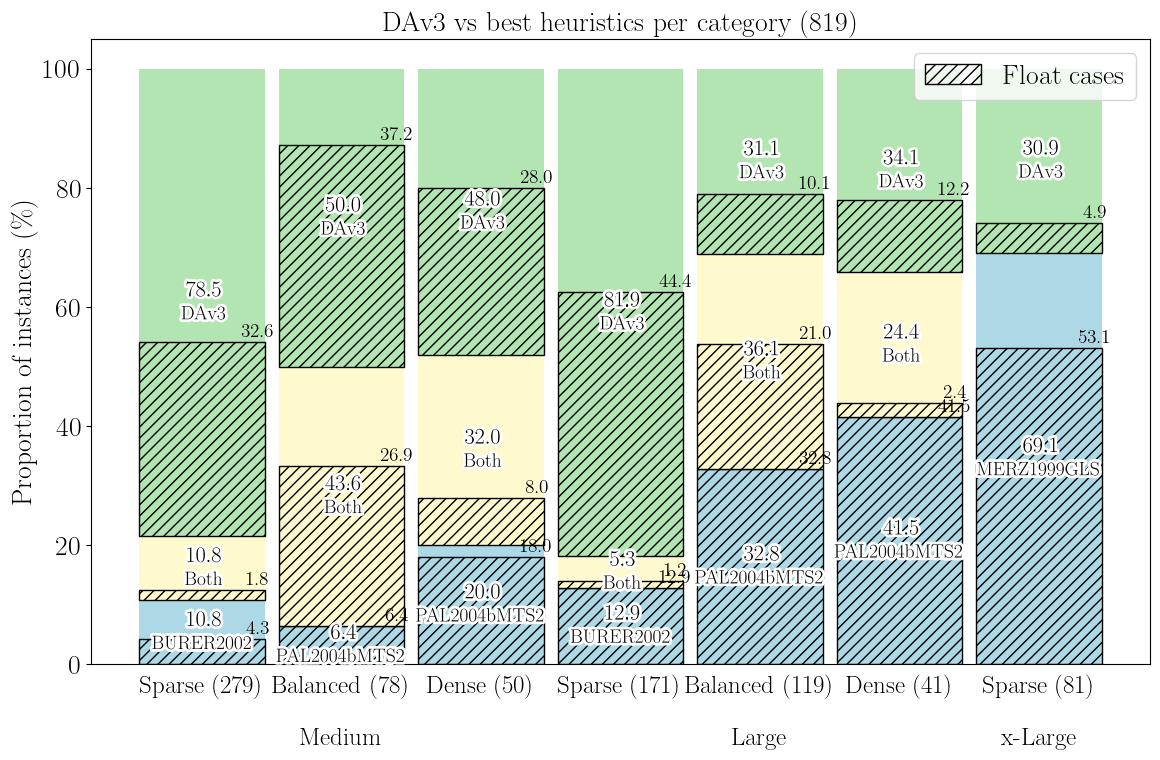

In [23]:
category_labels = {
    'med_sp': f'BURER2002 \n Sparse ({counts_v3[0]})',
    'med_ba': f'PAL2004bMTS2 \n  Balanced ({counts_v3[2]}) \n \n  Medium',
    'med_dens': f'PAL2004bMTS2 \n  Dense ({counts_v3[4]})',
    'large_sp': f'BURER2002 \n  Sparse ({counts_v3[6]})',
    'large_ba': f'PAL2004bMTS2 \n  Balanced ({counts_v3[8]}) \n \n Large',
    'large_dens': f'PAL2004bMTS2 \n  Dense ({counts_v3[10]})',
    'xlarge_sp': f'MERZ1999GLS \n Sparse ({counts_v3[12]}) \n \n x-Large'
}


colors = ['#ADD8E6', '#FFFACD', '#B2E5B2']

labels = [ 'Both', 'DAv3']


plt.figure(figsize=(12, 8))
for i, key in enumerate(category_labels.keys(), 1):
    base_vals = summary[key]
    float_vals = summary.get(f"{key}_flt", (0, 0, 0))
    total = sum(base_vals)
    label = [category_labels[key].partition('\n')[0]] + labels
    plot_stacked_bar_with_hatch(i, base_vals, float_vals, total, colors, label)



plt.xticks(ticks=range(1, len(category_labels) + 1), labels={k: v.partition('\n')[2] for k, v in category_labels.items()}.values())
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels = [0, 20, 40, 60, 80, 100])
plt.ylabel("Proportion of instances (\%)")
plt.title(f"DAv3 vs best heuristics per category ({sum([counts_v3[i] for i in [0,2,4,6,8,10,12]])})")
plt.legend()
plt.tick_params(axis='x', which='both', bottom=False, top=False)  # hides tick marks
plt.tight_layout()

#plt.savefig('plots/DAv3_vs_best_heuristics_per_category.pdf',bbox_inches="tight", dpi=300)

plt.show()

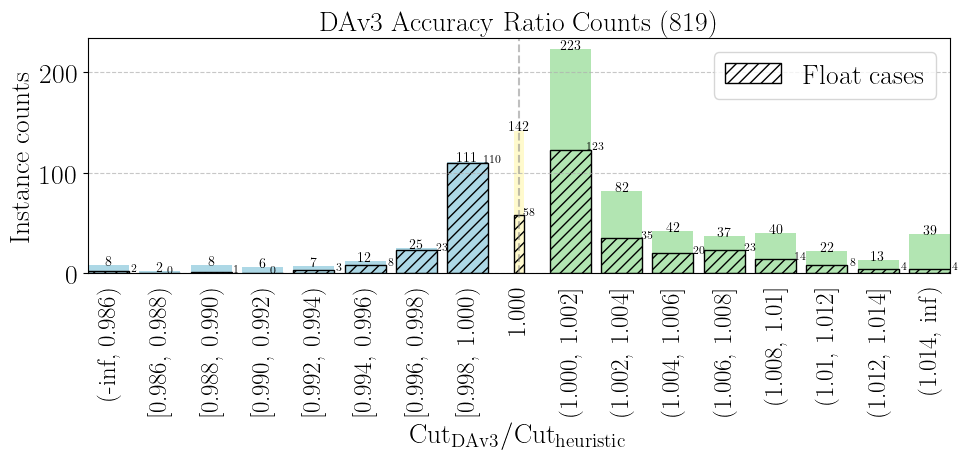

In [24]:
n_colors = 8
colors =  ['#ADD8E6' for i in range(1,n_colors+1)][::-1]
colors = colors + ['#FFFACD']
colors = colors + ['#B2E5B2' for i in range(1,n_colors+1)]

labels = [
    "(-inf, 0.986)","[0.986, 0.988)","[0.988, 0.990)", "[0.990, 0.992)", "[0.992, 0.994)",
    "[0.994, 0.996)", "[0.996, 0.998)",
    "[0.998, 1.000)", "{1.000}", "(1.000, 1.002]","(1.002, 1.004]",
     "(1.004, 1.006]", "(1.006, 1.008]",
     "(1.008, 1.01]","(1.01, 1.012]","(1.012, 1.014]", "(1.014, inf)"]



widths = [
    0.2 if lab == "{1.000}" else
    0.8
    for lab in labels
]

acc_v3_list = np.array(collect_all_values(all_results))
acc_v3_flt = np.array(collect_flt_values(all_results))

bin_indices = np.full(acc_v3_list.shape, -1)

# assign bins
bin_indices[acc_v3_list < 0.986] = 0
bin_indices[(acc_v3_list >= 0.986) & (acc_v3_list < 0.988)] = 1
bin_indices[(acc_v3_list >= 0.988) & (acc_v3_list < 0.990)] = 2
bin_indices[(acc_v3_list >= 0.990) & (acc_v3_list < 0.992)] = 3
bin_indices[(acc_v3_list >= 0.992) & (acc_v3_list < 0.994)] = 4
bin_indices[(acc_v3_list >= 0.994) & (acc_v3_list < 0.996)] = 5
bin_indices[(acc_v3_list >= 0.996) & (acc_v3_list < 0.998)] = 6
bin_indices[(acc_v3_list >= 0.998) & (acc_v3_list < 1.000)] = 7
bin_indices[acc_v3_list==1] = 8
bin_indices[(acc_v3_list > 1.000) & (acc_v3_list <= 1.002)] = 9
bin_indices[(acc_v3_list > 1.002) & (acc_v3_list <= 1.004)] = 10
bin_indices[(acc_v3_list > 1.004) & (acc_v3_list <= 1.006)] = 11
bin_indices[(acc_v3_list > 1.006) & (acc_v3_list <= 1.008)] = 12
bin_indices[(acc_v3_list > 1.008) & (acc_v3_list <= 1.01)] = 13
bin_indices[(acc_v3_list > 1.01) & (acc_v3_list <= 1.012)] = 14
bin_indices[(acc_v3_list > 1.012) & (acc_v3_list <= 1.014)] = 15
bin_indices[acc_v3_list > 1.014] = 16


counter = Counter(bin_indices)
counts = [counter.get(i, 0) for i in range(len(labels))]

total = sum(counts)
portions = [c / total for c in counts]

# Plot count
plt.figure(figsize=(10, 5))
plt.bar(labels, counts, color = colors, width=widths)
plt.axvline(8, linestyle='--', color='gray',alpha=0.5)
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center', fontsize=10, color='black')


# assign bins for float cases
bin_indices_flt = np.full(acc_v3_flt.shape, -1)
bin_indices_flt [acc_v3_flt < 0.986] = 0
bin_indices_flt [(acc_v3_flt >= 0.986) & (acc_v3_flt < 0.988)] = 1
bin_indices_flt [(acc_v3_flt >= 0.988) & (acc_v3_flt < 0.990)] = 2
bin_indices_flt [(acc_v3_flt >= 0.990) & (acc_v3_flt < 0.992)] = 3
bin_indices_flt [(acc_v3_flt >= 0.992) & (acc_v3_flt < 0.994)] = 4
bin_indices_flt [(acc_v3_flt >= 0.994) & (acc_v3_flt < 0.996)] = 5
bin_indices_flt [(acc_v3_flt >= 0.996) & (acc_v3_flt < 0.998)] = 6
bin_indices_flt [(acc_v3_flt >= 0.998) & (acc_v3_flt < 1.000)] = 7
bin_indices_flt [acc_v3_flt==1] = 8
bin_indices_flt [(acc_v3_flt > 1.000) & (acc_v3_flt <= 1.002)] = 9
bin_indices_flt [(acc_v3_flt > 1.002) & (acc_v3_flt <= 1.004)] = 10
bin_indices_flt [(acc_v3_flt > 1.004) & (acc_v3_flt <= 1.006)] = 11
bin_indices_flt [(acc_v3_flt > 1.006) & (acc_v3_flt <= 1.008)] = 12
bin_indices_flt [(acc_v3_flt > 1.008) & (acc_v3_flt <= 1.01)] = 13
bin_indices_flt [(acc_v3_flt > 1.01) & (acc_v3_flt <= 1.012)] = 14
bin_indices_flt [(acc_v3_flt > 1.012) & (acc_v3_flt <= 1.014)] = 15
bin_indices_flt [acc_v3_flt > 1.014] = 16

# Count flt values in each bin
counter_flt = Counter(bin_indices_flt)
counts_flt = [counter_flt.get(i, 0) for i in range(len(labels))]


portions_flt = [c / total for c in counts_flt]

# Overlay hashed bars
plt.bar(
    labels, counts_flt,
    color='none',             
    edgecolor='black',        
    width=widths,
    hatch='///',
    label='Float cases'
)

for i, count in enumerate(counts_flt):
    if count != 0 and labels[i] != '{1.000}':
        plt.text(i+0.5, count + 0.5, str(count), ha='center', fontsize=8, color='black')
    else: 
        plt.text(i+0.2, count + 0.5, str(count), ha='center', fontsize=8, color='black')
        


plt.xlabel(r"$\mathrm{Cut}_{\mathrm{DAv3}} / \mathrm{Cut}_{\mathrm{heuristic}}$")
plt.ylabel("Instance counts")
plt.xticks(rotation=90)
plt.tick_params(axis='x', which='both', bottom=False, top=False)  # hides tick marks
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.title(f"DAv3 Accuracy Ratio Counts ({sum([counts_v3[i] for i in [0,2,4,6,8,10,12]])})")
plt.tight_layout()
plt.xlim(-0.4,16.4)
plt.legend()

#plt.savefig('plots/DAv3_acc_ratio.pdf',bbox_inches="tight", dpi=300)

plt.show()

# DAv2 vs. best MQLib heuristics on x-small--small instances 

In [25]:
baseline = pd.read_csv('baseline.csv')
baseline_small = baseline[baseline['limit'] > 0.25] #first instances filter

solver = 'DAv2'

#second instances filter
categories = {
    'xs_sp': ((20, 1024), (0, 0.1), 'BURER2002'),
    'xs_ba':     ((20, 1024), (0.1, 0.5), 'PALUBECKIS2004bMST2'),
    'xs_dens':     ((20, 1024), (0.5, 1.1), 'PALUBECKIS2004bMST2'),
    's_sp': ((1024, 2048), (0, 0.1), 'BURER2002'),
    's_ba':     ((1024, 2048), (0.1, 0.5), 'PALUBECKIS2004bMST2'),
    's_dens':     ((1024, 2048), (0.5, 1.1), 'PALUBECKIS2004bMST2'),
}

In [26]:
# === Main Execution ===

all_results = {}
for key, (node_range, density_range, ref_solver) in categories.items():
    subset = get_baseline_subset(baseline_small, node_range, density_range)
    res, res_flt = compare_solver(folder_path, solver, subset, ref_solver)
    all_results[key] = {'all': res, 'flt': res_flt}


summary = {}
for cat, res_dict in all_results.items():
    summary[cat] = summarize_accuracy(res_dict['all'])
    summary[cat + '_flt'] = summarize_accuracy(res_dict['flt'])


counts_small=[]

for k, (win, lose, tie) in summary.items():
    print(f"{k}: Win={win}, Lose={lose}, Tie={tie}")
    counts_small.append(win+lose+tie)

xs_sp: Win=361, Lose=68, Tie=96
xs_sp_flt: Win=77, Lose=11, Tie=29
xs_ba: Win=79, Lose=28, Tie=260
xs_ba_flt: Win=43, Lose=22, Tie=127
xs_dens: Win=28, Lose=57, Tie=97
xs_dens_flt: Win=15, Lose=6, Tie=44
s_sp: Win=115, Lose=26, Tie=38
s_sp_flt: Win=30, Lose=6, Tie=1
s_ba: Win=22, Lose=8, Tie=11
s_ba_flt: Win=19, Lose=8, Tie=6
s_dens: Win=7, Lose=1, Tie=4
s_dens_flt: Win=5, Lose=0, Tie=1


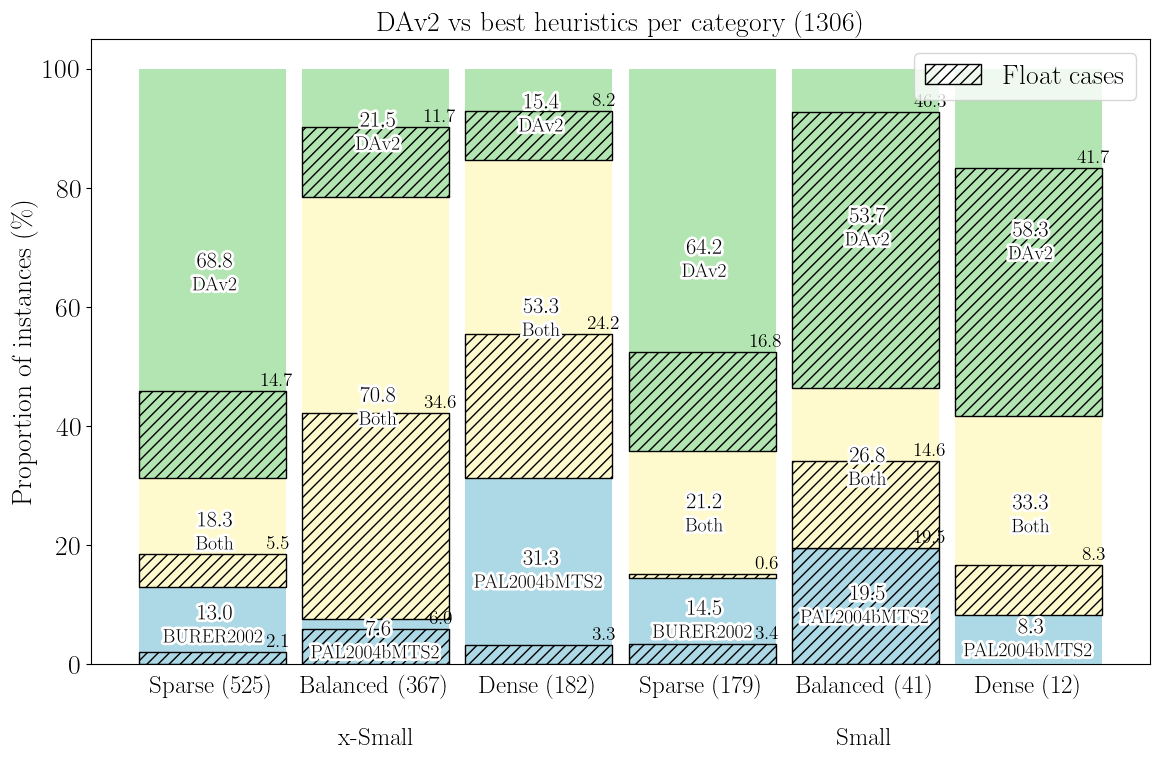

In [27]:

category_labels = {
    'xs_sp': f'BURER2002 \n Sparse ({counts_small[0]}) ',
    'xs_ba': f'PAL2004bMTS2 \n  Balanced ({counts_small[2]}) \n \n x-Small',
    'xs_dens': f'PAL2004bMTS2 \n Dense ({counts_small[4]})',
    's_sp': f'BURER2002 \n Sparse ({counts_small[6]}) ',
    's_ba': f'PAL2004bMTS2 \n  Balanced ({counts_small[8]}) \n \n Small',
    's_dens': f'PAL2004bMTS2 \n Dense ({counts_small[10]})',
}


colors = ['#ADD8E6', '#FFFACD', '#B2E5B2'] #['hotpink', 'lightpink', 'crimson']

labels = ['Both', 'DAv2']

plt.figure(figsize=(12, 8))
for i, key in enumerate(category_labels.keys(), 1):
    base_vals = summary[key]
    float_vals = summary.get(f"{key}_flt", (0, 0, 0))
    total = sum(base_vals)
    label = [category_labels[key].partition('\n')[0]] + labels
    plot_stacked_bar_with_hatch(i, base_vals, float_vals, total, colors, label)


plt.xticks(ticks=range(1, len(category_labels) + 1), labels={k: v.partition('\n')[2] for k, v in category_labels.items()}.values())
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels = [0, 20, 40, 60, 80, 100])
plt.ylabel("Proportion of instances (\%)")
plt.title(f"DAv2 vs best heuristics per category ({sum([counts_small[i] for i in [0,2,4,6,8,10]])})")
plt.tick_params(axis='x', which='both', bottom=False, top=False)  # hides tick marks
plt.legend()
plt.tight_layout()

#plt.savefig('plots/DAv2_vs_small_best_heuristics_per_category.pdf',bbox_inches="tight", dpi=300)

plt.show()

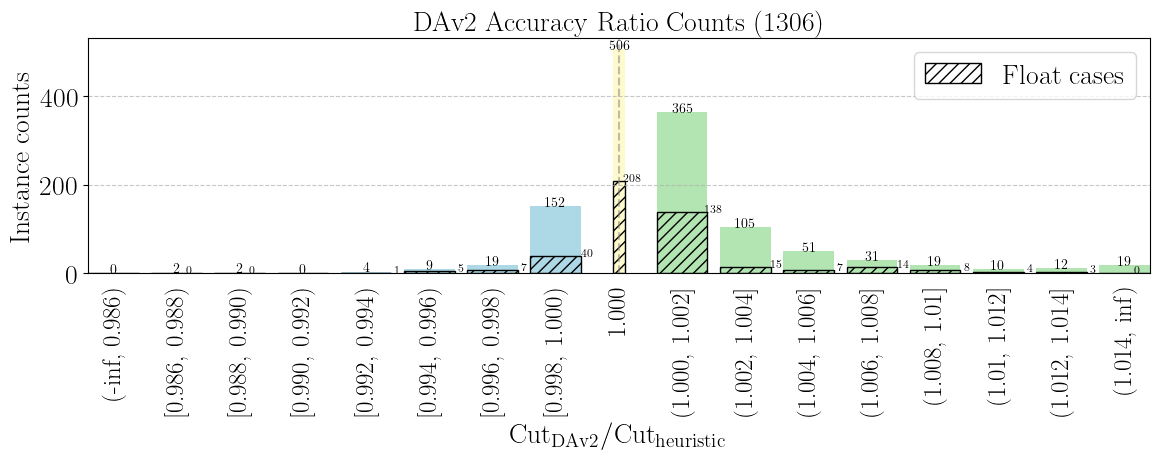

In [28]:
def collect_all_values(d):
    all_values = []
    for value in d.values():
        if isinstance(value, dict):  
            all_values.extend(value.get('all', []))  
    return all_values

def collect_flt_values(d):
    flt_values = []
    for value in d.values():
        if isinstance(value, dict):  
            flt_values.extend(value.get('flt', []))  
    return flt_values

n_colors = 8
colors =  ['#ADD8E6' for i in range(1,n_colors+1)][::-1]
colors = colors + ['#FFFACD']
colors = colors + ['#B2E5B2' for i in range(1,n_colors+1)]

labels = [
    "(-inf, 0.986)","[0.986, 0.988)","[0.988, 0.990)", "[0.990, 0.992)", "[0.992, 0.994)",
    "[0.994, 0.996)", "[0.996, 0.998)",
    "[0.998, 1.000)", "{1.000}", "(1.000, 1.002]","(1.002, 1.004]",
     "(1.004, 1.006]", "(1.006, 1.008]",
     "(1.008, 1.01]","(1.01, 1.012]","(1.012, 1.014]", "(1.014, inf)"]



widths = [
    0.2 if lab == "{1.000}" else
    0.8
    for lab in labels
]

acc_v2_list = np.array(collect_all_values(all_results))
acc_v2_flt = np.array(collect_flt_values(all_results))

bin_indices = np.full(acc_v2_list.shape, -1)

# assign bins
bin_indices[acc_v2_list < 0.986] = 0
bin_indices[(acc_v2_list >= 0.986) & (acc_v2_list < 0.988)] = 1
bin_indices[(acc_v2_list >= 0.988) & (acc_v2_list < 0.990)] = 2
bin_indices[(acc_v2_list >= 0.990) & (acc_v2_list < 0.992)] = 3
bin_indices[(acc_v2_list >= 0.992) & (acc_v2_list < 0.994)] = 4
bin_indices[(acc_v2_list >= 0.994) & (acc_v2_list < 0.996)] = 5
bin_indices[(acc_v2_list >= 0.996) & (acc_v2_list < 0.998)] = 6
bin_indices[(acc_v2_list >= 0.998) & (acc_v2_list < 1.000)] = 7
bin_indices[acc_v2_list==1] = 8
bin_indices[(acc_v2_list > 1.000) & (acc_v2_list <= 1.002)] = 9
bin_indices[(acc_v2_list > 1.002) & (acc_v2_list <= 1.004)] = 10
bin_indices[(acc_v2_list > 1.004) & (acc_v2_list <= 1.006)] = 11
bin_indices[(acc_v2_list > 1.006) & (acc_v2_list <= 1.008)] = 12
bin_indices[(acc_v2_list > 1.008) & (acc_v2_list <= 1.01)] = 13
bin_indices[(acc_v2_list > 1.01) & (acc_v2_list <= 1.012)] = 14
bin_indices[(acc_v2_list > 1.012) & (acc_v2_list <= 1.014)] = 15
bin_indices[acc_v2_list > 1.014] = 16


counter = Counter(bin_indices)
counts = [counter.get(i, 0) for i in range(len(labels))]

total = sum(counts)
portions = [c / total for c in counts]

# Plot count
plt.figure(figsize=(12, 5))
plt.bar(labels, counts, color = colors, width=widths)
plt.axvline(8, linestyle='--', color='gray',alpha=0.5)
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center', fontsize=10, color='black')

# assign bins for floats
bin_indices_flt = np.full(acc_v2_flt.shape, -1)
bin_indices_flt [acc_v2_flt < 0.986] = 0
bin_indices_flt [(acc_v2_flt >= 0.986) & (acc_v2_flt < 0.988)] = 1
bin_indices_flt [(acc_v2_flt >= 0.988) & (acc_v2_flt < 0.990)] = 2
bin_indices_flt [(acc_v2_flt >= 0.990) & (acc_v2_flt < 0.992)] = 3
bin_indices_flt [(acc_v2_flt >= 0.992) & (acc_v2_flt < 0.994)] = 4
bin_indices_flt [(acc_v2_flt >= 0.994) & (acc_v2_flt < 0.996)] = 5
bin_indices_flt [(acc_v2_flt >= 0.996) & (acc_v2_flt < 0.998)] = 6
bin_indices_flt [(acc_v2_flt >= 0.998) & (acc_v2_flt < 1.000)] = 7
bin_indices_flt [acc_v2_flt==1] = 8
bin_indices_flt [(acc_v2_flt > 1.000) & (acc_v2_flt <= 1.002)] = 9
bin_indices_flt [(acc_v2_flt > 1.002) & (acc_v2_flt <= 1.004)] = 10
bin_indices_flt [(acc_v2_flt > 1.004) & (acc_v2_flt <= 1.006)] = 11
bin_indices_flt [(acc_v2_flt > 1.006) & (acc_v2_flt <= 1.008)] = 12
bin_indices_flt [(acc_v2_flt > 1.008) & (acc_v2_flt <= 1.01)] = 13
bin_indices_flt [(acc_v2_flt > 1.01) & (acc_v2_flt <= 1.012)] = 14
bin_indices_flt [(acc_v2_flt > 1.012) & (acc_v2_flt <= 1.014)] = 15
bin_indices_flt [acc_v2_flt > 1.014] = 16

# Count flt values in each bin
counter_flt = Counter(bin_indices_flt)
counts_flt = [counter_flt.get(i, 0) for i in range(len(labels))]

portions_flt = [c / total for c in counts_flt]

# Overlay hashed bars
plt.bar(
    labels, counts_flt,
    color='none',             
    edgecolor='black',        
    width=widths,
    hatch='///',
    label='Float cases'
)

for i, count in enumerate(counts_flt):
    if count != 0 and labels[i] != '{1.000}':
        plt.text(i+0.5, count + 0.5, str(count), ha='center', fontsize=8, color='black')
    elif counts[i] == 0:
        pass
    else: 
        plt.text(i+0.2, count + 0.5, str(count), ha='center', fontsize=8, color='black')



plt.xlabel(r"$\mathrm{Cut}_{\mathrm{DAv2}} / \mathrm{Cut}_{\mathrm{heuristic}}$")
plt.ylabel("Instance counts")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.title(f"DAv2 Accuracy Ratio Counts ({sum([counts_small[i] for i in [0,2,4,6,8,10]])})")
plt.tick_params(axis='x', which='both', bottom=False, top=False)  # hides tick marks
plt.tight_layout()
plt.xlim(-0.4,16.4)
plt.legend()

#plt.savefig('plots/DAv2_small_acc_ratio.pdf',bbox_inches="tight", dpi=300)

plt.show()

# DAv3 vs Dwave

In [20]:
#read original data provided for D-Wave's HS white paper
# https://www.dwavequantum.com/media/4bnpi53x/14-1039a-b_d-wave_hybrid_solver_service_an_overview.pdf
Dwave = pd.read_csv('dwave_mqlib_hss_results.csv', converters={'objective':decimal_from_value})
hss_cols = [col for col in Dwave.columns if "hss_trial" in col]
Dwave["max_obj"] = Dwave[hss_cols].abs().max(axis=1)
Dwave.rename(columns={"graph_name": "name"}, inplace=True)

baseline= pd.read_csv('baseline.csv')

In [27]:
getcontext().prec = 50

def decimal_from_value(value):
    return Decimal(value)

def str_from_value(value):
    return str(value)

with open('DWave-DAv3/progress.json') as fp:
    data = json.load(fp)

DAv3 = []

for name in Dwave['name']:
    DA_instance_runs = all_df[all_df['file'] == './DWave-DAv3'+ f'/{name}-{1200}-5.csv']
    for i in range(5):
        DAv3.append({"name": name, "objective": DA_instance_runs['objective'].iloc[i]})

DAv3_df = pd.DataFrame(DAv3)

objectives = {case: {
        'DWave': sorted([-list(Dwave[Dwave['name'] == case][f'hss_trial_{idx}'])[0] for idx in range(1, 5+1)]),
        'DAv3': sorted(DAv3_df[DAv3_df['name']==case]['objective'])    
    } for case in data}

int_cases =  sorted([case for case in data.keys() if data[case]['int_only']], key=lambda case : data[case]['nodes']) 
float_cases = sorted([case for case in data.keys() if not data[case]['int_only']], key=lambda case : data[case]['nodes'])

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x18be6d74b20>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x18be6d754e0>)

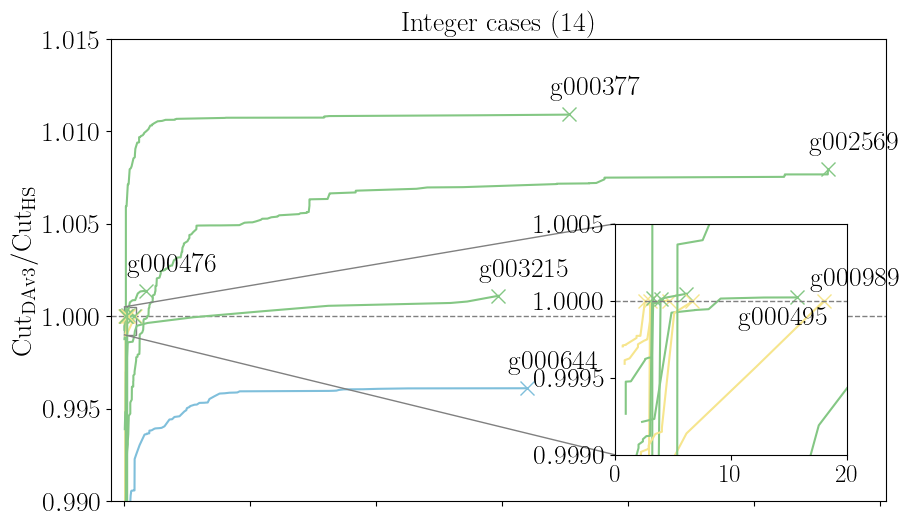

In [29]:
#Integer cases

cases = int_cases 

N = len(cases) 

colors = ['#84C784','#F6E58D', '#7FBFDB']

fig, ax = plt.subplots(figsize=(10,6))

ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1, label='y = 1')

plt.ylabel('')
ax.set_ylim(0.99,1.015)
ax.set_xlim(-20.1210)

axins = ax.inset_axes([0.65, 0.1, 0.3, 0.5])


for i, case in enumerate(cases):
    if case in objectives:
        best_DWave = max(objectives[case]['DWave'])
        scaling_factor = data[case]['scaling_factor']
        max_abs_val = max(abs(lst[-1][1]) for lst in data[case]['progress'])
        candidates = [lst for lst in data[case]['progress'] if abs(lst[-1][1]) == max_abs_val]
        best_list = min(candidates, key=lambda lst: lst[-1][0])

        x_vals = [entry[0] for entry in best_list]
        y_vals = [(-entry[1] / scaling_factor) / best_DWave for entry in best_list]

        #for assigning proper colors to the progress lines
        if y_vals[-1] > 1:
            j=0
        elif y_vals[-1] == 1:
            j=1
        elif y_vals[-1] < 1:
            j=2
            
        ax.plot(x_vals , y_vals, color = colors[j])
        ax.plot(x_vals[-1], y_vals[-1], marker='x', color=colors[j], markersize=10)

        #printing the name for some instances
        if x_vals[-1] > 20:
            plt.text(x_vals[-1]-30, y_vals[-1] +0.001, str(case))
            
        axins.plot(x_vals , y_vals, color = colors[j])
        axins.plot(x_vals[-1], y_vals[-1], marker='x', color=colors[j], markersize=10)
        
        #just for arranging text for readability
        if case == "g000989":
            axins.text(x_vals[-1]-1.2, y_vals[-1]+0.00009 , str(case))
        if case == "g000495":
            axins.text(x_vals[-1]-5, y_vals[-1] - 0.00018, str(case)) 


ax.set_title("Integer cases (14)")
ax.set_xticks(range(0, 1300, 200))
xticks = ax.get_xticks()
ax.set_xticklabels([' ' for _ in xticks])
ax.set_ylim(0.99,1.015)
ax.set_xlim(-20,1210)
ax.set_xlabel(" ")
plt.ylabel(r"$\mathrm{Cut}_{\mathrm{DAv3}} / \mathrm{Cut}_{\mathrm{HS}}$")

x1, x2 = 0, 20
y1, y2 = 0.999, 1.0005
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axhline(y=1, color='gray', linestyle='--', linewidth=1, label='y = 1')


mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="gray")

#plt.savefig('plots/colors_Int_bestDA_progress.pdf',bbox_inches="tight", dpi=300)

(0.9985, 1.0065)

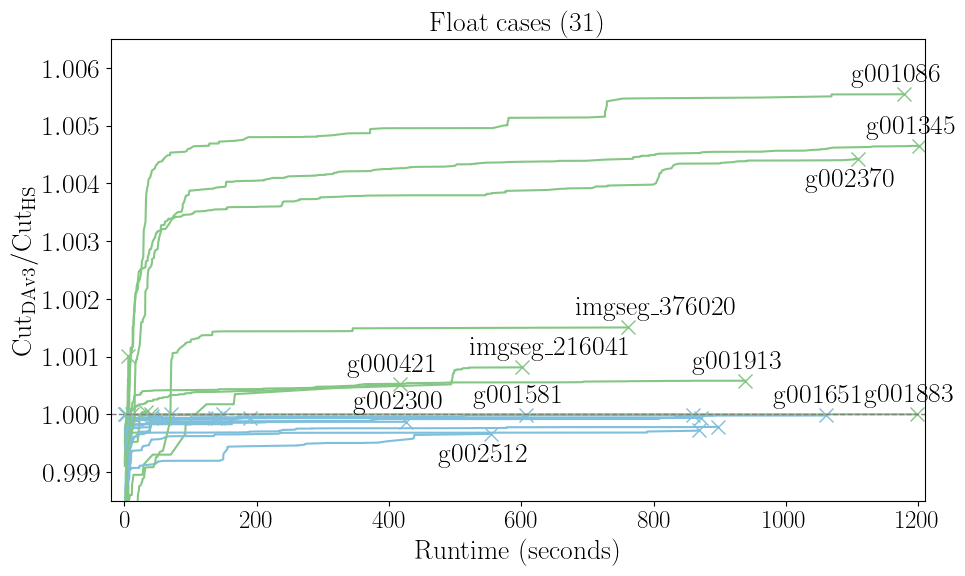

In [30]:
#Float cases

cases = float_cases 

N = len(cases) 

colors = ['#84C784','#F6E58D','#7FBFDB']

plt.close()
fig, ax = plt.subplots(figsize=(10.5,6))

for i, case in enumerate(cases):
    if case in objectives:
        best_DWave = Decimal(max(objectives[case]['DWave']))
        scaling_factor = Decimal(data[case]['scaling_factor'])
        max_abs_val = Decimal(max(abs(lst[-1][1]) for lst in data[case]['progress']))
        candidates = [lst for lst in data[case]['progress'] if abs(lst[-1][1]) == max_abs_val]
        best_list = min(candidates, key=lambda lst: lst[-1][0])
        
        x_vals = [entry[0] for entry in best_list]
        y_vals = [float((- Decimal(entry[1]) / scaling_factor) / best_DWave) for entry in best_list]


        if y_vals[-1] > 1:
            j=0
        elif y_vals[-1] == 1:
            j=1
        elif y_vals[-1] < 1:
            j=2
        
        ax.plot(x_vals , y_vals, color = colors[j])

    
        if x_vals[-1] > 800 and y_vals[-1] < 1 and x_vals[-1] < 1000:
            pass
        elif case == "g002370" or case == "g002512":
            plt.text(x_vals[-1]-80, y_vals[-1] -0.0005, str(case))
        elif x_vals[-1] > 200:
            plt.text(x_vals[-1]-80, y_vals[-1] +0.0002, str(case))

            
        ax.plot(x_vals[-1], y_vals[-1], marker='x', color=colors[j], markersize=10)

ax.set_title("Float cases (31)")
ax.set_xlim(-20,1210)
ax.set_ylim(0.9985,1.006)
ax.set_xticks(range(0, 1300, 200))
ax.axhline(y=1, color='gray', linestyle='--', linewidth=1, label='y = 1')
plt.xlabel('Runtime (seconds)')
plt.ylabel(r"$\mathrm{Cut}_{\mathrm{DAv3}} / \mathrm{Cut}_{\mathrm{HS}}$")

ax.set_ylim(0.9985,1.0065)

#plt.savefig('plots/colors_Flt_bestDA_progress.pdf',bbox_inches="tight", dpi=300)

## Accuracy ranges 

- Each cell has been analyzed separately at different times, therefore it is not optimized.  
- **TODO:** Read the files once


In [21]:
datai = []

for name in Dwave['name']:
    DA_instance_runs = all_df[all_df['file'] == './DWave-DAv3'+ f'/{name}-{1200}-5.csv']
    
    if not DA_instance_runs.empty:  # Ensure the dataframe is not empty
        DA_max_row = DA_instance_runs[DA_instance_runs["objective"] == DA_instance_runs["objective"].max()]
        DA_max_obj = DA_max_row["objective"]
        datai.append({"name": name, "max_cut": DA_max_obj})

df = pd.DataFrame(datai)
df = pd.merge(df, Dwave[['name','max_obj']], on='name', how='inner')

df = pd.merge(df, baseline[['name','int_only', 'limit']], on="name", how='inner')

#Integer cases
solver = 'DWave-DAv3'
df_int=df[df['int_only']==True]
acc_v3_dwave_int = []
diff_v3_dwave_int = []

for name, limit in zip(df_int['name'], df_int['limit']):
    DA_instance_runs = all_df[all_df['file'] == './DWave-DAv3'+ f'/{name}-{1200}-5.csv']
    DA_max_obj = DA_instance_runs["objective"].max()

    Dwave_obj = Dwave[Dwave['name'] == name]['max_obj'].values[0]


    acc_v3_dwave_int.append(DA_max_obj/Decimal(Dwave_obj))
    #diff_v3_dwave_int.append(abs(DA_max_obj-Dwave_obj)/Dwave_obj)

In [53]:
per_v3_below_998 = 0
per_v3_998_999 = 0
per_v3_999_1 = 0
per_v3_tie = 0
per_v3_1_1001 = 0
per_v3_1001_1002 = 0
per_v3_above_1002 = 0

for i in acc_v3_dwave_int:
    if i < 0.998:
        per_v3_below_998 += 1
    elif 0.998 <= i < 0.999:
        per_v3_998_999 += 1
    elif 0.999 <= i < 1.0:
        per_v3_999_1 += 1
    elif i == 1.0:
        per_v3_tie += 1
    elif 1.0 < i <= 1.001:
        per_v3_1_1001 += 1
    elif 1.001 < i <= 1.002:
        per_v3_1001_1002 += 1
    elif i > 1.002:
        per_v3_above_1002 += 1

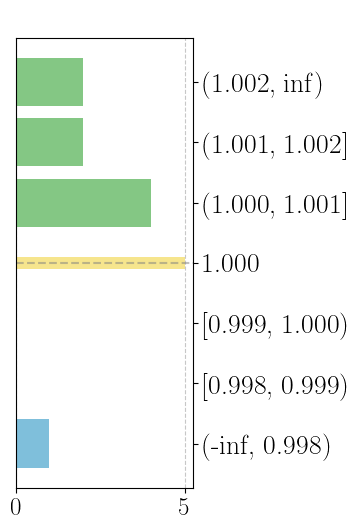

In [54]:
categories = [
    "(-inf, 0.998)", "[0.998, 0.999)", "[0.999, 1.000)", "{1.000}", 
    "(1.000, 1.001]", "(1.001, 1.002]", "(1.002, inf)"]
counts = [per_v3_below_998,per_v3_998_999,per_v3_999_1,per_v3_tie,per_v3_1_1001,per_v3_1001_1002,per_v3_above_1002]
  

n_colors = 3
colors =  ['#7FBFDB' for i in range(1,n_colors+1)][::-1]
colors = colors + ['#F6E58D']
colors = colors + ['#84C784' for i in range(1,n_colors+1)]


heights = [0.8 if lab != "{1.000}" else 0.2 for lab in categories]

plt.figure(figsize=(4, 5.7))
plt.axhline(3, linestyle='--', color='gray', alpha=0.5)
plt.barh(categories, counts, color=colors, height=heights)

plt.grid(axis="x", linestyle="--", alpha=0.7)  
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")


plt.title(" ")
plt.tight_layout()

#plt.savefig('plots/DAv3_vs_Dwave_int.pdf',bbox_inches="tight", dpi=300)


plt.show()

In [24]:
df_flt=df[df['int_only']==False]

acc_v3_dwave_flt = []
diff_v3_dwave_flt = []

for name, limit in zip(df_flt['name'], df_flt['limit']):
    DA_instance_runs = all_df[all_df['file'] == './DWave-DAv3'+ f'/{name}-{1200}-5.csv']
    DA_max_obj = DA_instance_runs["objective"].max()

    Dwave_obj = Decimal(Dwave[Dwave['name'] == name]['max_obj'].values[0])

    

    acc_v3_dwave_flt.append(DA_max_obj/Dwave_obj)
    #diff_v3_dwave_flt.append(abs(DA_max_obj-Dwave_obj)/Dwave_obj)

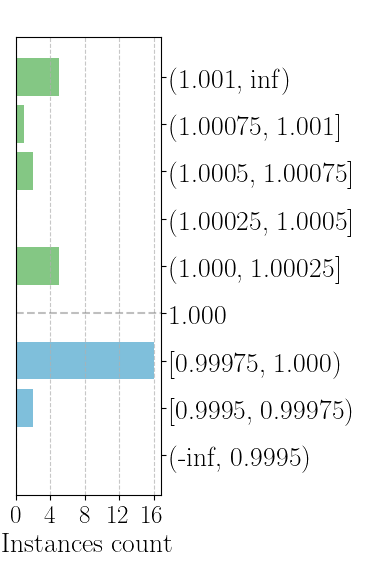

In [56]:
per_v3_1=0
#per_v3_2=0
#per_v3_3=0
per_v3_4=0
per_v3_5=0
per_v3_tie=0
per_v3_6=0
per_v3_7=0
per_v3_8=0
per_v3_9=0
per_v3_10=0


for i in acc_v3_dwave_flt:
    if (i < 0.9995):
        per_v3_1 += 1
    if (i>=0.9995) and (i<0.99975):
        per_v3_4 += 1
    if (i>=0.99975) and (i<1):
        per_v3_5 += 1
    if (i == 1):
        per_v3_tie += 1
    if (i>1) and (i <= 1.00025):
        per_v3_6 += 1
    if (i>1.00025) and (i <= 1.0005):
        per_v3_7 += 1
    if (i>1.0005) and (i <= 1.00075):
        per_v3_8 += 1
    if (i>1.00075) and (i <= 1.001):
        per_v3_9 += 1
    if (i > 1.001):
        per_v3_10 += 1

categories = [
    "(-inf, 0.9995)", "[0.9995, 0.99975)", "[0.99975, 1.000)", "{1.000}",
    "(1.000, 1.00025]", "(1.00025, 1.0005]", "(1.0005, 1.00075]", "(1.00075, 1.001]", "(1.001, inf)"]
counts = [per_v3_1,per_v3_4,per_v3_5,per_v3_tie,per_v3_6,per_v3_7,per_v3_8,per_v3_9,per_v3_10]

n_colors = 5
colors =  ['#7FBFDB' for i in range(1,n_colors-1)][::-1]
colors = colors + ['#F6E58D']
colors = colors + ['#84C784' for i in range(1,n_colors+1)]


heights = [0.8 if lab != "{1.000}" else 0.2 for lab in categories]

plt.figure(figsize=(4, 5.5))
plt.axhline(3, linestyle='--', color='gray', alpha=0.5)
plt.barh(categories, counts, color=colors, height=heights)


plt.tight_layout()

from matplotlib.ticker import MaxNLocator
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel("Instances count")               
plt.xticks([0, 4, 8, 12, 16])
plt.title(" ")
plt.grid(axis="x", linestyle="--", alpha=0.7)  
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")

#plt.savefig('plots/DAv3_vs_Dwave_flt.pdf',bbox_inches="tight", dpi=300)

plt.show()

# MQLib heuristics exceeding the time limit

- Each cell has been analyzed separately at different times, therefore it is not optimized.  
- **TODO:** Produce plots by defining a function.

In [44]:
baseline = pd.read_csv('baseline.csv')
baseline = baseline[baseline['limit'] > 0.25]
#v2_instances = baseline[baseline['nodes'] >= 20]
v2_instances = baseline[baseline['nodes'] < 8192]
v3_instances = baseline[baseline['nodes'] >= 2048]

In [45]:
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['lmodern'],  # This name works when LaTeX rendering is enabled
    'font.size': 20,
    'axes.titlesize': 20,        # title font size
    'axes.labelsize': 20,        # axis label size
    'xtick.labelsize': 20,       # x tick font size
    'ytick.labelsize': 20      # y tick font size
})

In [46]:
ratios_v2 = []
solver = 'DAv2'

j=0 

for name, limit in zip(v2_instances['name'], v2_instances['limit']):
    DA_instance_runs = all_df[all_df['file']== f"./{solver}/{name}-{limit:.3f}-5.csv"]
    #obtain the maximum objective value for the instance
    DA_max_row = DA_instance_runs['objective'].max()
    #obtain all runs (out of 5) that achieved this maximum objective value
    best_rows = DA_instance_runs[DA_instance_runs['objective'] == DA_max_row]
    #pick the run that has the minimum runtime
    best_row = best_rows.loc[best_rows['runtime'].idxmin()]
    #Calculate the ratio of runtime to the time limit
    ratios_v2.append((best_row['runtime']/baseline[baseline['name']==name]['limit']).iloc[0])


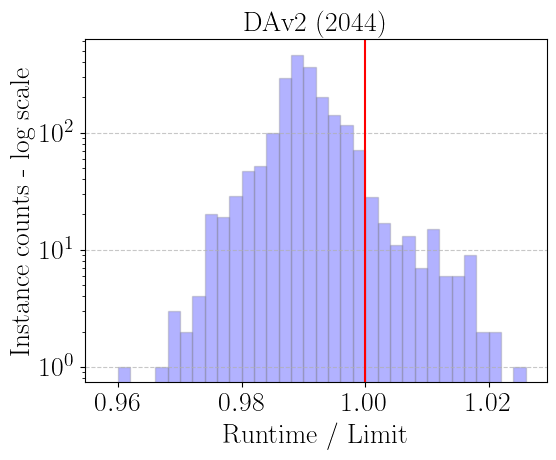

In [47]:
plt.figure(figsize=(6, 5))
bins = plt.hist(ratios_v2, np.arange(np.round(min(ratios_v2),2)-0.002, max(ratios_v2)+0.002, 0.002), color='blue', edgecolor='gray', alpha = 0.3)
plt.axvline(1, linestyle='-', color = 'red')

plt.xlabel('Runtime / Limit')
plt.ylabel('Instance counts - log scale')
plt.title('DAv2 (' + str(len(ratios_v2)) +')')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.yscale('log')

#plt.savefig('plots/DAv2_hist_time.pdf',bbox_inches="tight", dpi=300)
plt.show()

In [48]:
ratios_v3 = []
solver = 'DAv3'

for name, limit in zip(v3_instances['name'], v3_instances['limit']):
    DA_instance_runs = all_df[all_df['file']== f"./{solver}/{name}-{max(1, limit_after_offset(limit, 3))}-5.csv"]
    DA_max_row = DA_instance_runs['objective'].max()
    best_rows = DA_instance_runs[DA_instance_runs['objective'] == DA_max_row]
    best_row = best_rows.loc[best_rows['runtime'].idxmin()]
    ratios_v3.append((best_row['runtime']/baseline[baseline['name']==name]['limit']).iloc[0])

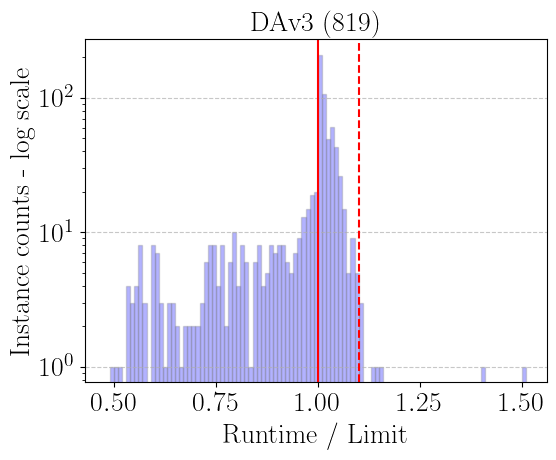

In [49]:
plt.figure(figsize=(6, 5))
bins = plt.hist(ratios_v3, np.arange(np.round(min(ratios_v3),2)-0.01, max(ratios_v3)+0.01, 0.01), color='blue', edgecolor='gray', alpha = 0.3)
plt.axvline(1, linestyle='-', color = 'red')
plt.axvline(1.1, linestyle='--', color = 'red')


plt.xlabel('Runtime / Limit')
plt.ylabel('Instance counts - log scale')
plt.title('DAv3 (' + str(len(ratios_v3)) +')')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.yscale('log')

#plt.savefig('plots/DAv3_hist_time.pdf',bbox_inches="tight", dpi=300)
plt.show()

In [50]:
v3_instances = baseline[baseline['nodes'] < 2048]
ratios_v3 = []
solver = 'DAv3'

j=0 

for name, limit in zip(v3_instances['name'], v3_instances['limit']):
    DA_instance_runs = all_df[all_df['file']== f"./{solver}/{name}-{max(1, limit_after_offset(limit, 3) - 0)}-5.csv"]
    DA_max_row = DA_instance_runs['objective'].max()
    best_rows = DA_instance_runs[DA_instance_runs['objective'] == DA_max_row]
    best_row = best_rows.loc[best_rows['runtime'].idxmin()]
    ratios_v3.append((best_row['runtime']/baseline[baseline['name']==name]['limit']).iloc[0])

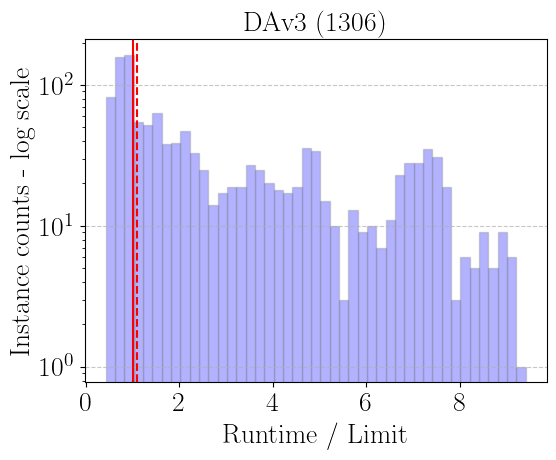

In [51]:
plt.figure(figsize=(6, 5))
bins = plt.hist(ratios_v3, np.arange(np.round(min(ratios_v3),2)-0.01, max(ratios_v3)+0.01, 0.2), color='blue', edgecolor='gray', alpha = 0.3)
plt.axvline(1, linestyle='-', color = 'red')
plt.axvline(1.1, linestyle='--', color = 'red')


plt.xlabel('Runtime / Limit')
plt.ylabel('Instance counts - log scale')
plt.title('DAv3 (' + str(len(ratios_v3)) +')')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.yscale('log')

#plt.savefig('plots/DAv3_hist_time_small.pdf',bbox_inches="tight", dpi=300)
plt.show()

In [52]:
ratios_bur= []
solver = 'BURER2002'

for name, limit in zip(v2_instances['name'], v2_instances['limit']):
    instance_runs = all_df[all_df['file']== f"./{solver}/{name}-{limit:.3f}-5.csv"]    
    max_row = instance_runs['objective'].max()
    best_rows = instance_runs[instance_runs['objective'] == max_row]
    best_row = best_rows.loc[best_rows['runtime'].idxmin()]
    ratios_bur.append((best_row['runtime']/baseline[baseline['name']==name]['limit']).iloc[0])

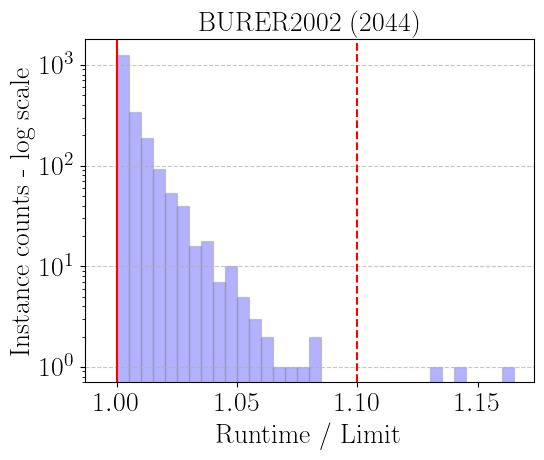

In [53]:
plt.figure(figsize=(6, 5))
plt.hist(ratios_bur, np.arange(np.round(min(ratios_bur),2)-0.005, max(ratios_bur)+0.005, 0.005), color='blue', edgecolor='gray', alpha = 0.3)
plt.axvline(1, linestyle='-', color = 'red')
plt.axvline(1.1, linestyle='--', color = 'red')

plt.xlabel('Runtime / Limit')
plt.ylabel('Instance counts - log scale')
plt.title('BURER2002 (' + str(len(ratios_bur)) + ')')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.yscale('log')

#plt.savefig('plots/Burer_hist_time.pdf',bbox_inches="tight", dpi=300)
plt.show()

In [54]:
ratios_pal= []
solver = 'PALUBECKIS2004bMST2'

for name, limit in zip(v2_instances['name'], v2_instances['limit']):
    instance_runs = all_df[all_df['file']== f"./{solver}/{name}-{limit:.3f}-5.csv"]
    max_row = instance_runs['objective'].max()
    best_rows = instance_runs[instance_runs['objective'] == max_row]
    best_row = best_rows.loc[best_rows['runtime'].idxmin()]
    ratios_pal.append((best_row['runtime']/baseline[baseline['name']==name]['limit']).iloc[0])

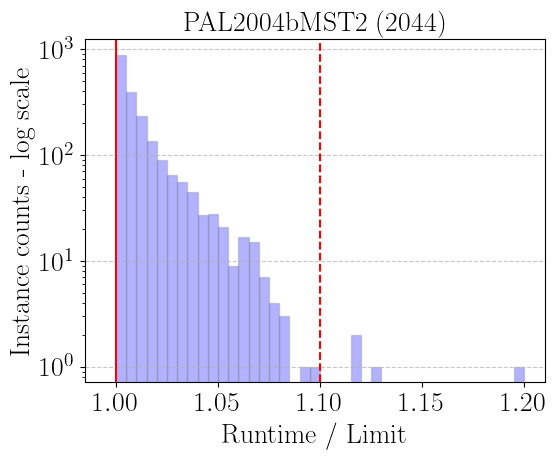

In [55]:
plt.figure(figsize=(6, 5))
plt.hist(ratios_pal, np.arange(np.round(min(ratios_pal),2)-0.005, max(ratios_pal)+0.005, 0.005), color='blue', edgecolor='gray', alpha = 0.3)
plt.axvline(1, linestyle='-', color = 'red')
plt.axvline(1.1, linestyle='--', color = 'red')

plt.xlabel('Runtime / Limit')
plt.ylabel('Instance counts - log scale')
plt.title('PAL2004bMST2 (' + str(len(ratios_pal)) + ')')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.yscale('log')

#plt.savefig('plots/Palubecki_hist_time.pdf',bbox_inches="tight", dpi=300)
plt.show()

In [56]:
baseline_x=baseline[baseline['nodes'] >= 8192]
ratios_merz= []
solver = 'MERZ1999GLS'

for name, limit in zip(baseline_x['name'], baseline_x['limit']):
    instance_runs = all_df[all_df['file']== f"./{solver}/{name}-{limit:.3f}-5.csv"]
    max_row = instance_runs['objective'].max()
    best_rows = instance_runs[instance_runs['objective'] == max_row]
    best_row = best_rows.loc[best_rows['runtime'].idxmin()]
    ratios_merz.append((best_row['runtime']/baseline[baseline['name']==name]['limit']).iloc[0])

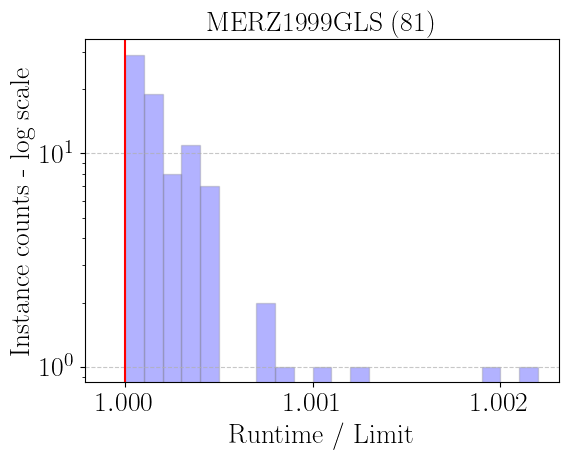

In [57]:
plt.figure(figsize=(6, 5))
plt.hist(ratios_merz, np.arange(np.round(min(ratios_merz),2)-0.0001, max(ratios_merz)+0.0001, 0.0001), color='blue', edgecolor='gray', alpha = 0.3)
plt.axvline(1, linestyle='-', color = 'red')


plt.xlabel('Runtime / Limit')
plt.ylabel('Instance counts - log scale')
plt.title('MERZ1999GLS (' + str(len(ratios_merz)) + ')')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.yscale('log')

#plt.savefig('plots/Merz_hist_time.pdf',bbox_inches="tight", dpi=300)
plt.show()

# DA vs. QIS3

In [9]:
#for highliting the table later
def highlight_max(s):
    # Convert to numeric, skip NaNs
    numeric_s = pd.to_numeric(s, errors='coerce')
    max_val = numeric_s.max(skipna=True)
    return ['background-color: lightgray; font-weight: bold' if (v == max_val) else '' for v in numeric_s]

In [10]:
cases = ['G11', 'G32', 'G48', 'G57', 'G62', 'G65', 'G66', 'G72', 'G14', 'G51', 'G35', 'G58', 'G63', 'G1', 'G43', 'G22']

data = {} # version / limit / 

for version in ['DAv2', 'DAv3']:
    data[version] = {}
    for limit in range(1, 11):
        data[version][limit] = {}
        t =  f'{limit:.3f}' if (version == "DAv2") else f'{limit:d}' 
        for name in cases:
            #case = os.path.basename(filename).replace(f'-{t}-5.csv', '')
            csv = all_df[all_df['file'] == './GSet-'+ f'{version}/{name}-{t}-5.csv']
            if len(csv) > 0:
                max_cut = csv['objective'].max()
                
                #take the minimum time of 5 runs per instacne
                min_duration_at_max_cut = csv[csv['objective'] == max_cut]['runtime'].min() 
                data[version][limit][name] = (max_cut, min_duration_at_max_cut)


In [11]:
#DAv2
Table = np.empty((0,4))
for i, case in enumerate(cases):
    diff = np.inf
    if case == 'G66' or case == 'G72': #For DAv2 (instances with sizes larger than 8192)
        time = 0
        objective = 0
        limit = 0
        Table = np.append(Table, np.array([[case,int(objective),np.round(time,3),limit]]), axis = 0)

    else:
        for s in range(1,11): #a loop to choose the run with the least absolute deviation from 10 seconds
            if diff > np.abs(data['DAv2'][s][case][1] - 10):
                diff = np.abs(data['DAv2'][s][case][1] - 10)
                time = data['DAv2'][s][case][1]
                objective = data['DAv2'][s][case][0]
                limit = s

            
        
        Table = np.append(Table, np.array([[case,int(objective),np.round(time,3),limit]]), axis = 0)


data_table_v2 = pd.DataFrame(Table)
data_table_v2.columns = ['name','DAv2','time_v2','limit_v2']
data_table_v2['DAv2'] = pd.to_numeric(data_table_v2['DAv2'], errors='coerce')

In [12]:
#DAv3
Table = np.empty((0,4))
for i, case in enumerate(cases):
    diff = np.inf

    for s in range(1,11):
        if diff > np.abs(data['DAv3'][s][case][1] - 10):
            diff = np.abs(data['DAv3'][s][case][1] - 10)
            time = data['DAv3'][s][case][1]
            objective = data['DAv3'][s][case][0]
            limit = s
        
    Table = np.append(Table, np.array([[case,int(objective),np.round(time,3),limit]]), axis = 0)

data_table_v3 = pd.DataFrame(Table)
data_table_v3.columns = ['name','DAv3','time_v3','limit_v3']
data_table_v3['DAv3'] = pd.to_numeric(data_table_v3['DAv3'], errors='coerce')

In [13]:
Gset = cases

#QIS3 results from their original work
#https://arxiv.org/abs/2506.04596

QIS3 = [
    564, 1404, 6000, 3466, 4828, 5502, 6288, 6916,
    3060, 3846, 7673, 19216, 26949,
    11624, 6660, 13358
]

V = [800, 2000, 3000, 5000, 7000, 8000, 9000, 10000, 800, 1000, 2000, 5000, 7000, 800, 1000, 2000]
E = [1600, 4000, 6000, 10000, 14000, 16000, 18000, 20000, 4694, 5909, 11778, 29570, 41459, 19176, 9990, 19990]

D=[]
for i in range(len(cases)):
    D.append(np.round(2*E[i]/(V[i]*(V[i]-1)),4))

In [14]:
QIS = pd.DataFrame({'name':Gset, '|V|':V, 'Density':D, 'QIS3':QIS3, 'limit':[10 for i in range(len(cases))]})

In [15]:
Full_table = pd.merge(QIS, pd.merge(data_table_v2.replace('0', '-').replace(0, '-'), data_table_v3,how='outer', on='name'), how='outer', on='name')
Full_table.style.apply(lambda s: highlight_max(s), axis=1, subset=Full_table.columns[3:])

,name,|V|,Density,QIS3,limit,DAv2,time_v2,limit_v2,DAv3,time_v3,limit_v3
0,G11,800,0.005000,564,10,564,9.866,10,564,10.983,10
1,G32,2000,0.002000,1404,10,1410,9.91,10,1410,9.652,8
2,G48,3000,0.001300,6000,10,6000,9.838,10,6000,8.795,8
3,G57,5000,0.000800,3466,10,3470,9.959,10,3482,8.737,6
4,G62,7000,0.000600,4828,10,4838,9.961,10,4846,10.759,7
5,G65,8000,0.000500,5502,10,5460,10.139,10,5534,12.166,8
6,G66,9000,0.000400,6288,10,-,-,-,6182,8.76,8
7,G72,10000,0.000400,6916,10,-,-,-,6728,8.906,5
8,G14,800,0.014700,3060,10,3064,9.866,10,3064,10.978,10
9,G51,1000,0.011800,3846,10,3848,9.869,10,3848,11.034,9


(0.97, 1.008)

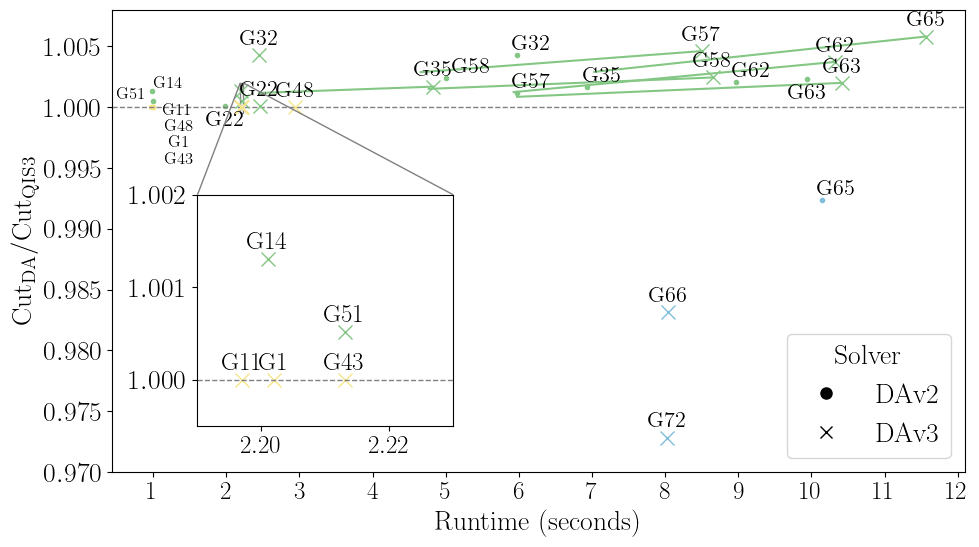

In [16]:
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import json


cases = Full_table['name']

N = len(cases) 

colors = ['#84C784','#F6E58D', '#7FBFDB']

plt.close()
fig, ax = plt.subplots(figsize=(11,6))

ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1, label='y = 1')


plt.ylabel(r"$\mathrm{Cut}_{\mathrm{DA}} / \mathrm{Cut}_{\mathrm{QIS3}}$")
plt.xlabel('Runtime (seconds)')

axins = ax.inset_axes([0.1, 0.1, 0.3, 0.5])

#DAv3 progress plot
for name, limit in zip(Full_table['name'],Full_table['limit_v3']):

    with open(folder_path+ 'GSet-DAv3' + f'/{name}-{limit}-5.json') as fp:
        data_json = json.load(fp)

    #choose the run with the best objective value and the minimum runtime
    max_abs_val = max(abs(lst[-1][1]) for lst in data_json)
    candidates = [lst for lst in data_json if abs(lst[-1][1]) == max_abs_val]
    best_list = min(candidates, key=lambda lst: lst[-1][0])


    x_vals = [entry[0] for entry in best_list]
    y_vals = [-entry[1]/Full_table[Full_table['name']==name]['QIS3'].values[0] for entry in best_list]

    #for assigning proper colors to the progress lines
    if y_vals[-1] > 1:
        j=0
    elif y_vals[-1] == 1:
        j=1
    elif y_vals[-1] < 1:
        j=2
    
    #plot the progress line for each instance
    ax.plot(x_vals , y_vals, color = colors[j])
    ax.plot(x_vals[-1], y_vals[-1], marker='x', color=colors[j], markersize=10)
    axins.plot(x_vals , y_vals, color = colors[j])
    axins.plot(x_vals[-1], y_vals[-1], marker='x', color=colors[j], markersize=10)

    #to avoind overlapping text
    if x_vals[-1] > 2.22:
        ax.text(x_vals[-1] , y_vals[-1] + 0.0005, str(name), ha='center', va='bottom', fontsize=16)

    if x_vals[-1] < 2.22:
        axins.text(x_vals[-1] , y_vals[-1] + 0.00005, str(name), ha='center', va='bottom', fontsize=18)


ax.set_xticks(range(0, 13, 1))
xticks = ax.get_xticks()

x1, x2 = 2.19, 2.23
y1, y2 = 0.9995, 1.002
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axhline(y=1, color='gray', linestyle='--', linewidth=1)
axins.yaxis.set_label_position("right")

# Connect the inset with the main plot
mark_inset(ax, axins, loc1=1, loc2=2, fc="none", ec="gray")

#DAv2 (not a progress plot but data from time limit offset from 0 to 9)
i=0
for case in cases:
    if case == 'G66' or case == 'G72': #Cannot fit DAv2 (exceed 8192 nodes)
        pass
    else:
        for s in range(1,11):
            if data_table_v2[data_table_v2['name']==case]['DAv2'].values[0] == data['DAv2'][s][case][0]:
               
                    #for assigning proper colors to the progress lines
                    if data['DAv2'][s][case][0]/Full_table[Full_table['name']==case]['QIS3'].values[0] > 1:
                        j=0
                    elif data['DAv2'][s][case][0]/Full_table[Full_table['name']==case]['QIS3'].values[0] == 1:
                        j=1
                    elif data['DAv2'][s][case][0]/Full_table[Full_table['name']==case]['QIS3'].values[0] < 1:
                        j=2
                        
                    
                    plt.scatter(data['DAv2'][s][case][1], data['DAv2'][s][case][0]/Full_table[Full_table['name']==case]['QIS3'].values[0], marker = '.', color = colors[j])
                    
                
                    #shift text around for some data points for readability
                    if abs(data['DAv2'][s][case][0]/Full_table[Full_table['name']==case]['QIS3'].values[0] - 1) == 0.0:
                        plt.text(float(data['DAv2'][s][case][1]) + 0.35   , float(data['DAv2'][s][case][0]/Full_table[Full_table['name']==case]['QIS3'].values[0]) - 0.0009 - i/150, str(case), ha='center', va='bottom', fontsize=12)
                        i+=0.2
                    elif case == "G63" or case == "G22" :
                        plt.text(float(data['DAv2'][s][case][1])   , float(data['DAv2'][s][case][0]/Full_table[Full_table['name']==case]['QIS3'].values[0]) - 0.002 , str(case), ha='center', va='bottom', fontsize=16)
                    elif case == "G58":
                        plt.text(float(data['DAv2'][s][case][1]) + 0.35 , float(data['DAv2'][s][case][0]/Full_table[Full_table['name']==case]['QIS3'].values[0]) + 0.00005, str(case), ha='center', va='bottom', fontsize=16)
                    elif case == "G51":
                        plt.text(float(data['DAv2'][s][case][1]) - 0.3 , float(data['DAv2'][s][case][0]/Full_table[Full_table['name']==case]['QIS3'].values[0]) - 0.00009, str(case), ha='center', va='bottom', fontsize=12)
                    elif case == "G14":
                        plt.text(float(data['DAv2'][s][case][1]) + 0.2 , float(data['DAv2'][s][case][0]/Full_table[Full_table['name']==case]['QIS3'].values[0]) + 0.00005, str(case), ha='center', va='bottom', fontsize=12)
                    else: 
                        plt.text(float(data['DAv2'][s][case][1]) + 0.2 , float(data['DAv2'][s][case][0]/Full_table[Full_table['name']==case]['QIS3'].values[0]) + 0.00005, str(case), ha='center', va='bottom', fontsize=16)
                    break


# Create legend handles manually
dot_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=8, label='DAv2')
cross_handle = mlines.Line2D([], [], color='black', marker='x', linestyle='None', markersize=8, label='DAv3')

# Force the legend onto the plot
plt.legend(handles=[dot_handle, cross_handle], title='Solver', loc='lower right')
plt.ylim(0.97,1.008)

#plt.savefig('plots/DA_vs_QIS3_progress.pdf',bbox_inches="tight", dpi=300)